# Assignment 1 - Image Classification

This notebook contains the required task for the first assignment of the Software for Advanced Machine Learning course. Read the task description and implement the empty code cells. Each section represents a stage along implementing an image classifier, from loading and inspecting the dataset to training a **pre-trained** Convolutional Neural Network architecture. The sections are to guide you but you do not have to follow that specific order. 

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [Canvas](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise training and evaluation can be very slow.

## Rules and Comments
- From the list of datasets and architectures listed in canvas, each student was atributed **1 dataset and 1 architecture** to use within this assignment. Please confirm yours in the Canvas assignment's description. 
- This is an DL class so to pass the homework you do have to implement a working classifier, just loading the data or having a "random-guess" performance is not enough.
- As always, copying others' code will make you fail the homework automatically (and thus the course). Remember that you will have to defend the assignment at the end of the semester.
- **Deadline is March 25**
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID below for easier identification.

**Name: Viktor Habony**  
**Neptun ID: H8SCMR** 

## Task description
Your task is to train an already pretrained Convolutional Neural Network architecture on a dataset, both given in canvas. The datasets contain images as input and class labels as target, thus you have to solve a Supervised Machine Learning Classification problem. 

The dataset shoud be divided into train, validation and test set, for which results should be presented for all.

You can either train the architecture you were given without changing its layers, or you can add more layers, if you believe it increases the accuracy. There is no expected percentage of accuracy, but **your accuracy should be better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualisations (any of the following: matplotlib, seaborn, tensorboard, ...) of the accuracy and loss and use Early stopping while training your network.



## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [1]:
# ADD YOUR CODE HERE

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import pandas as pd
import seaborn as sn
import time
import glob
import shutil
import os
import sys
import copy

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models


from sklearn import preprocessing
from collections import Counter
from scipy.io import loadmat
from torch.optim import lr_scheduler
from tabulate import tabulate
from collections import Counter
from statistics import mean
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score,  precision_score, recall_score
%matplotlib inline

## 1. Dataset 
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

#### Loading the device


In [2]:
# Available CUDA devices
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
NVIDIA GeForce RTX 3060


#### Loading the dataset
Show some images and labels of your dataset

In [3]:
# ADD YOUR CODE HERE

# Creating the necessary folders for training and testing
def prepare_images(src_path, dst_path):
    
    labels       = []
    train        = []
    val          = []
    labels       = []
    
    src_dir          = src_path
    dst_dir          = dst_path + '/'
    train_dir        = dst_dir + 'train'
    val_dir          = dst_dir + 'val'
    dest_directories = [train_dir, val_dir]
    
    cars_train_annos = loadmat('devkit/cars_train_annos.mat')
    cars_meta        = loadmat('devkit/cars_meta.mat')

    # Get the classes from meta file (196 class)
    for l in cars_meta['class_names'][0]:
        labels.append(l[0])

    for example in cars_train_annos['annotations'][0]:

        label = labels[example[-2][0][0] - 1] # The class name
        image = example[-1][0] # The image name
        train.append((image,label))

    # Creating subfolders for the classes (training, validation)
    for directory in dest_directories:
        for label in labels:
            if(not os.path.exists(os.path.join(directory, label))):
                os.makedirs(os.path.join(directory, label))
                
    i = 0

    # Copying all images to the train folder    
    for img in train:

        s = shutil.copy(src_dir + '/' + img[0], train_dir + '/' + img[1] + '/')

        if len(s) != 0:
            i += 1
            print("Copying the " + str(i) + ". image to the " + train_dir + '/' + img[1] + " directory")  
        else:
            print("Something went wrong with the " + src_dir + '/' + img[1] + '/' + img[0] + 'image')

    cnt = 0

    # Copying 20% of the images to the validation and test folder
    for subdir in labels:
        for img in os.listdir(train_dir + '/' + subdir):

            length = int(len(os.listdir(train_dir + '/' + subdir)) * 0.2)

            if cnt < length:
                shutil.move(train_dir + '/' + subdir + '/' + img, val_dir + '/' + subdir + '/')
                cnt += 1
        cnt = 0    
    
            
    # Get the number of labels, the images and the images / category
    dataset_classes_size = []
    dataset_sizes        = []
    x                    = [i for i in range(len(labels))]
    y                    = []   
    
    summa = 0

    for directory in dest_directories:
        for subdir in labels:
            
            y.append((subdir, len(os.listdir(directory + '/' + subdir))))
            summa += len(os.listdir(directory + '/' + subdir))
            
        dataset_classes_size.append(y)
        dataset_sizes.append(summa)
        summa = 0
        y     = []

    #y.sort(key=lambda x:x[1])
    
    return x, dataset_classes_size, dataset_sizes


In [4]:
x, dataset_classes_size, dataset_sizes  = prepare_images('cars_train', 'dataset')

Copying the 1. image to the dataset/train/Audi TTS Coupe 2012 directory
Copying the 2. image to the dataset/train/Acura TL Sedan 2012 directory
Copying the 3. image to the dataset/train/Dodge Dakota Club Cab 2007 directory
Copying the 4. image to the dataset/train/Hyundai Sonata Hybrid Sedan 2012 directory
Copying the 5. image to the dataset/train/Ford F-450 Super Duty Crew Cab 2012 directory
Copying the 6. image to the dataset/train/Geo Metro Convertible 1993 directory
Copying the 7. image to the dataset/train/Dodge Journey SUV 2012 directory
Copying the 8. image to the dataset/train/Dodge Charger Sedan 2012 directory
Copying the 9. image to the dataset/train/Mitsubishi Lancer Sedan 2012 directory
Copying the 10. image to the dataset/train/Chevrolet Traverse SUV 2012 directory
Copying the 11. image to the dataset/train/Buick Verano Sedan 2012 directory
Copying the 12. image to the dataset/train/Toyota Sequoia SUV 2012 directory
Copying the 13. image to the dataset/train/Hyundai Elantr

Copying the 117. image to the dataset/train/Bentley Continental GT Coupe 2012 directory
Copying the 118. image to the dataset/train/Rolls-Royce Phantom Sedan 2012 directory
Copying the 119. image to the dataset/train/Jeep Liberty SUV 2012 directory
Copying the 120. image to the dataset/train/Mercedes-Benz 300-Class Convertible 1993 directory
Copying the 121. image to the dataset/train/Ford Expedition EL SUV 2009 directory
Copying the 122. image to the dataset/train/BMW 1 Series Coupe 2012 directory
Copying the 123. image to the dataset/train/Jaguar XK XKR 2012 directory
Copying the 124. image to the dataset/train/Cadillac Escalade EXT Crew Cab 2007 directory
Copying the 125. image to the dataset/train/BMW 3 Series Sedan 2012 directory
Copying the 126. image to the dataset/train/Chevrolet Cobalt SS 2010 directory
Copying the 127. image to the dataset/train/Chrysler 300 SRT-8 2010 directory
Copying the 128. image to the dataset/train/Audi A5 Coupe 2012 directory
Copying the 129. image to

Copying the 235. image to the dataset/train/Ford Ranger SuperCab 2011 directory
Copying the 236. image to the dataset/train/Acura ZDX Hatchback 2012 directory
Copying the 237. image to the dataset/train/Chevrolet Avalanche Crew Cab 2012 directory
Copying the 238. image to the dataset/train/BMW ActiveHybrid 5 Sedan 2012 directory
Copying the 239. image to the dataset/train/Audi V8 Sedan 1994 directory
Copying the 240. image to the dataset/train/Hyundai Sonata Sedan 2012 directory
Copying the 241. image to the dataset/train/Nissan Juke Hatchback 2012 directory
Copying the 242. image to the dataset/train/Ferrari California Convertible 2012 directory
Copying the 243. image to the dataset/train/Nissan Leaf Hatchback 2012 directory
Copying the 244. image to the dataset/train/Acura ZDX Hatchback 2012 directory
Copying the 245. image to the dataset/train/Chevrolet Impala Sedan 2007 directory
Copying the 246. image to the dataset/train/Mitsubishi Lancer Sedan 2012 directory
Copying the 247. ima

Copying the 347. image to the dataset/train/Jeep Patriot SUV 2012 directory
Copying the 348. image to the dataset/train/Chevrolet Corvette Convertible 2012 directory
Copying the 349. image to the dataset/train/Dodge Journey SUV 2012 directory
Copying the 350. image to the dataset/train/Dodge Ram Pickup 3500 Crew Cab 2010 directory
Copying the 351. image to the dataset/train/Bentley Continental GT Coupe 2012 directory
Copying the 352. image to the dataset/train/Isuzu Ascender SUV 2008 directory
Copying the 353. image to the dataset/train/Ford Fiesta Sedan 2012 directory
Copying the 354. image to the dataset/train/Chevrolet Corvette Ron Fellows Edition Z06 2007 directory
Copying the 355. image to the dataset/train/Nissan Juke Hatchback 2012 directory
Copying the 356. image to the dataset/train/Ford Focus Sedan 2007 directory
Copying the 357. image to the dataset/train/Bentley Continental Supersports Conv. Convertible 2012 directory
Copying the 358. image to the dataset/train/BMW 3 Series

Copying the 447. image to the dataset/train/Mercedes-Benz C-Class Sedan 2012 directory
Copying the 448. image to the dataset/train/Scion xD Hatchback 2012 directory
Copying the 449. image to the dataset/train/Spyker C8 Coupe 2009 directory
Copying the 450. image to the dataset/train/Audi R8 Coupe 2012 directory
Copying the 451. image to the dataset/train/Toyota 4Runner SUV 2012 directory
Copying the 452. image to the dataset/train/Ford Freestar Minivan 2007 directory
Copying the 453. image to the dataset/train/GMC Acadia SUV 2012 directory
Copying the 454. image to the dataset/train/Buick Verano Sedan 2012 directory
Copying the 455. image to the dataset/train/Volvo 240 Sedan 1993 directory
Copying the 456. image to the dataset/train/Bentley Continental GT Coupe 2012 directory
Copying the 457. image to the dataset/train/GMC Terrain SUV 2012 directory
Copying the 458. image to the dataset/train/Ford Freestar Minivan 2007 directory
Copying the 459. image to the dataset/train/Dodge Caliber

Copying the 550. image to the dataset/train/Eagle Talon Hatchback 1998 directory
Copying the 551. image to the dataset/train/Bentley Continental GT Coupe 2012 directory
Copying the 552. image to the dataset/train/Bugatti Veyron 16.4 Coupe 2009 directory
Copying the 553. image to the dataset/train/Toyota Camry Sedan 2012 directory
Copying the 554. image to the dataset/train/Hyundai Sonata Sedan 2012 directory
Copying the 555. image to the dataset/train/Jaguar XK XKR 2012 directory
Copying the 556. image to the dataset/train/Mercedes-Benz SL-Class Coupe 2009 directory
Copying the 557. image to the dataset/train/Suzuki SX4 Sedan 2012 directory
Copying the 558. image to the dataset/train/Daewoo Nubira Wagon 2002 directory
Copying the 559. image to the dataset/train/Mercedes-Benz C-Class Sedan 2012 directory
Copying the 560. image to the dataset/train/Ford Mustang Convertible 2007 directory
Copying the 561. image to the dataset/train/Audi S5 Convertible 2012 directory
Copying the 562. image

Copying the 666. image to the dataset/train/Suzuki SX4 Sedan 2012 directory
Copying the 667. image to the dataset/train/Hyundai Elantra Sedan 2007 directory
Copying the 668. image to the dataset/train/Chrysler Crossfire Convertible 2008 directory
Copying the 669. image to the dataset/train/Chevrolet Silverado 1500 Classic Extended Cab 2007 directory
Copying the 670. image to the dataset/train/Acura RL Sedan 2012 directory
Copying the 671. image to the dataset/train/Hyundai Genesis Sedan 2012 directory
Copying the 672. image to the dataset/train/GMC Savana Van 2012 directory
Copying the 673. image to the dataset/train/Dodge Ram Pickup 3500 Crew Cab 2010 directory
Copying the 674. image to the dataset/train/GMC Savana Van 2012 directory
Copying the 675. image to the dataset/train/BMW Z4 Convertible 2012 directory
Copying the 676. image to the dataset/train/Chevrolet Impala Sedan 2007 directory
Copying the 677. image to the dataset/train/FIAT 500 Convertible 2012 directory
Copying the 678

Copying the 780. image to the dataset/train/Audi 100 Wagon 1994 directory
Copying the 781. image to the dataset/train/Dodge Sprinter Cargo Van 2009 directory
Copying the 782. image to the dataset/train/Ferrari FF Coupe 2012 directory
Copying the 783. image to the dataset/train/Chrysler 300 SRT-8 2010 directory
Copying the 784. image to the dataset/train/Ferrari 458 Italia Convertible 2012 directory
Copying the 785. image to the dataset/train/Audi S5 Coupe 2012 directory
Copying the 786. image to the dataset/train/Volkswagen Golf Hatchback 1991 directory
Copying the 787. image to the dataset/train/Infiniti G Coupe IPL 2012 directory
Copying the 788. image to the dataset/train/Ford Focus Sedan 2007 directory
Copying the 789. image to the dataset/train/Mercedes-Benz C-Class Sedan 2012 directory
Copying the 790. image to the dataset/train/Hyundai Santa Fe SUV 2012 directory
Copying the 791. image to the dataset/train/Hyundai Elantra Sedan 2007 directory
Copying the 792. image to the datase

Copying the 891. image to the dataset/train/Tesla Model S Sedan 2012 directory
Copying the 892. image to the dataset/train/Toyota 4Runner SUV 2012 directory
Copying the 893. image to the dataset/train/Ford Mustang Convertible 2007 directory
Copying the 894. image to the dataset/train/Honda Odyssey Minivan 2012 directory
Copying the 895. image to the dataset/train/Hyundai Veracruz SUV 2012 directory
Copying the 896. image to the dataset/train/Bentley Continental Flying Spur Sedan 2007 directory
Copying the 897. image to the dataset/train/Bentley Continental Flying Spur Sedan 2007 directory
Copying the 898. image to the dataset/train/Acura Integra Type R 2001 directory
Copying the 899. image to the dataset/train/Audi S6 Sedan 2011 directory
Copying the 900. image to the dataset/train/Rolls-Royce Phantom Drophead Coupe Convertible 2012 directory
Copying the 901. image to the dataset/train/Jaguar XK XKR 2012 directory
Copying the 902. image to the dataset/train/Toyota 4Runner SUV 2012 dire

Copying the 993. image to the dataset/train/Ford Focus Sedan 2007 directory
Copying the 994. image to the dataset/train/Ford GT Coupe 2006 directory
Copying the 995. image to the dataset/train/Chevrolet Sonic Sedan 2012 directory
Copying the 996. image to the dataset/train/Ferrari 458 Italia Coupe 2012 directory
Copying the 997. image to the dataset/train/Chevrolet HHR SS 2010 directory
Copying the 998. image to the dataset/train/Chevrolet Traverse SUV 2012 directory
Copying the 999. image to the dataset/train/Chevrolet Traverse SUV 2012 directory
Copying the 1000. image to the dataset/train/GMC Savana Van 2012 directory
Copying the 1001. image to the dataset/train/Bentley Continental GT Coupe 2007 directory
Copying the 1002. image to the dataset/train/Bentley Continental GT Coupe 2007 directory
Copying the 1003. image to the dataset/train/Volkswagen Beetle Hatchback 2012 directory
Copying the 1004. image to the dataset/train/Chevrolet Corvette ZR1 2012 directory
Copying the 1005. imag

Copying the 1104. image to the dataset/train/Tesla Model S Sedan 2012 directory
Copying the 1105. image to the dataset/train/Acura ZDX Hatchback 2012 directory
Copying the 1106. image to the dataset/train/Mitsubishi Lancer Sedan 2012 directory
Copying the 1107. image to the dataset/train/Chevrolet Cobalt SS 2010 directory
Copying the 1108. image to the dataset/train/Chevrolet Corvette Convertible 2012 directory
Copying the 1109. image to the dataset/train/Mitsubishi Lancer Sedan 2012 directory
Copying the 1110. image to the dataset/train/Suzuki SX4 Sedan 2012 directory
Copying the 1111. image to the dataset/train/Toyota 4Runner SUV 2012 directory
Copying the 1112. image to the dataset/train/Volvo C30 Hatchback 2012 directory
Copying the 1113. image to the dataset/train/Dodge Sprinter Cargo Van 2009 directory
Copying the 1114. image to the dataset/train/Chevrolet Express Van 2007 directory
Copying the 1115. image to the dataset/train/BMW 3 Series Sedan 2012 directory
Copying the 1116. i

Copying the 1217. image to the dataset/train/Mazda Tribute SUV 2011 directory
Copying the 1218. image to the dataset/train/Mercedes-Benz 300-Class Convertible 1993 directory
Copying the 1219. image to the dataset/train/Chrysler PT Cruiser Convertible 2008 directory
Copying the 1220. image to the dataset/train/GMC Acadia SUV 2012 directory
Copying the 1221. image to the dataset/train/Infiniti QX56 SUV 2011 directory
Copying the 1222. image to the dataset/train/Chevrolet Express Cargo Van 2007 directory
Copying the 1223. image to the dataset/train/Jeep Liberty SUV 2012 directory
Copying the 1224. image to the dataset/train/Bentley Continental Supersports Conv. Convertible 2012 directory
Copying the 1225. image to the dataset/train/Toyota Camry Sedan 2012 directory
Copying the 1226. image to the dataset/train/Toyota 4Runner SUV 2012 directory
Copying the 1227. image to the dataset/train/BMW X3 SUV 2012 directory
Copying the 1228. image to the dataset/train/Bugatti Veyron 16.4 Convertible 

Copying the 1348. image to the dataset/train/BMW X3 SUV 2012 directory
Copying the 1349. image to the dataset/train/Jaguar XK XKR 2012 directory
Copying the 1350. image to the dataset/train/MINI Cooper Roadster Convertible 2012 directory
Copying the 1351. image to the dataset/train/Ford GT Coupe 2006 directory
Copying the 1352. image to the dataset/train/Bentley Arnage Sedan 2009 directory
Copying the 1353. image to the dataset/train/BMW 6 Series Convertible 2007 directory
Copying the 1354. image to the dataset/train/Lincoln Town Car Sedan 2011 directory
Copying the 1355. image to the dataset/train/Suzuki SX4 Sedan 2012 directory
Copying the 1356. image to the dataset/train/Nissan Leaf Hatchback 2012 directory
Copying the 1357. image to the dataset/train/Bentley Continental Flying Spur Sedan 2007 directory
Copying the 1358. image to the dataset/train/Chevrolet Camaro Convertible 2012 directory
Copying the 1359. image to the dataset/train/Chrysler Crossfire Convertible 2008 directory
Co

Copying the 1452. image to the dataset/train/Dodge Dakota Club Cab 2007 directory
Copying the 1453. image to the dataset/train/Volkswagen Beetle Hatchback 2012 directory
Copying the 1454. image to the dataset/train/GMC Canyon Extended Cab 2012 directory
Copying the 1455. image to the dataset/train/Jaguar XK XKR 2012 directory
Copying the 1456. image to the dataset/train/GMC Yukon Hybrid SUV 2012 directory
Copying the 1457. image to the dataset/train/Audi R8 Coupe 2012 directory
Copying the 1458. image to the dataset/train/Ford F-150 Regular Cab 2012 directory
Copying the 1459. image to the dataset/train/Chevrolet Tahoe Hybrid SUV 2012 directory
Copying the 1460. image to the dataset/train/Ram C/V Cargo Van Minivan 2012 directory
Copying the 1461. image to the dataset/train/Dodge Charger Sedan 2012 directory
Copying the 1462. image to the dataset/train/Jeep Wrangler SUV 2012 directory
Copying the 1463. image to the dataset/train/Mercedes-Benz S-Class Sedan 2012 directory
Copying the 146

Copying the 1566. image to the dataset/train/Toyota Camry Sedan 2012 directory
Copying the 1567. image to the dataset/train/Rolls-Royce Ghost Sedan 2012 directory
Copying the 1568. image to the dataset/train/BMW X3 SUV 2012 directory
Copying the 1569. image to the dataset/train/Porsche Panamera Sedan 2012 directory
Copying the 1570. image to the dataset/train/Hyundai Accent Sedan 2012 directory
Copying the 1571. image to the dataset/train/Plymouth Neon Coupe 1999 directory
Copying the 1572. image to the dataset/train/Chrysler Crossfire Convertible 2008 directory
Copying the 1573. image to the dataset/train/Chevrolet Corvette Convertible 2012 directory
Copying the 1574. image to the dataset/train/Ferrari 458 Italia Convertible 2012 directory
Copying the 1575. image to the dataset/train/Ferrari 458 Italia Coupe 2012 directory
Copying the 1576. image to the dataset/train/Dodge Challenger SRT8 2011 directory
Copying the 1577. image to the dataset/train/Chrysler Crossfire Convertible 2008 d

Copying the 1675. image to the dataset/train/BMW M5 Sedan 2010 directory
Copying the 1676. image to the dataset/train/Eagle Talon Hatchback 1998 directory
Copying the 1677. image to the dataset/train/Bentley Continental Flying Spur Sedan 2007 directory
Copying the 1678. image to the dataset/train/Aston Martin Virage Convertible 2012 directory
Copying the 1679. image to the dataset/train/Chevrolet Express Cargo Van 2007 directory
Copying the 1680. image to the dataset/train/Aston Martin V8 Vantage Coupe 2012 directory
Copying the 1681. image to the dataset/train/BMW X6 SUV 2012 directory
Copying the 1682. image to the dataset/train/Dodge Caliber Wagon 2012 directory
Copying the 1683. image to the dataset/train/Dodge Ram Pickup 3500 Crew Cab 2010 directory
Copying the 1684. image to the dataset/train/Lamborghini Aventador Coupe 2012 directory
Copying the 1685. image to the dataset/train/Dodge Challenger SRT8 2011 directory
Copying the 1686. image to the dataset/train/Ford F-150 Regular C

Copying the 1788. image to the dataset/train/Dodge Sprinter Cargo Van 2009 directory
Copying the 1789. image to the dataset/train/Dodge Ram Pickup 3500 Quad Cab 2009 directory
Copying the 1790. image to the dataset/train/Ford F-150 Regular Cab 2012 directory
Copying the 1791. image to the dataset/train/Nissan Juke Hatchback 2012 directory
Copying the 1792. image to the dataset/train/Bentley Continental Supersports Conv. Convertible 2012 directory
Copying the 1793. image to the dataset/train/Ford E-Series Wagon Van 2012 directory
Copying the 1794. image to the dataset/train/Scion xD Hatchback 2012 directory
Copying the 1795. image to the dataset/train/Chrysler Town and Country Minivan 2012 directory
Copying the 1796. image to the dataset/train/Chrysler Town and Country Minivan 2012 directory
Copying the 1797. image to the dataset/train/Land Rover Range Rover SUV 2012 directory
Copying the 1798. image to the dataset/train/Nissan 240SX Coupe 1998 directory
Copying the 1799. image to the d

Copying the 1901. image to the dataset/train/Acura ZDX Hatchback 2012 directory
Copying the 1902. image to the dataset/train/GMC Canyon Extended Cab 2012 directory
Copying the 1903. image to the dataset/train/Dodge Caravan Minivan 1997 directory
Copying the 1904. image to the dataset/train/Chrysler Aspen SUV 2009 directory
Copying the 1905. image to the dataset/train/Chevrolet Silverado 2500HD Regular Cab 2012 directory
Copying the 1906. image to the dataset/train/Chrysler Aspen SUV 2009 directory
Copying the 1907. image to the dataset/train/Ford Ranger SuperCab 2011 directory
Copying the 1908. image to the dataset/train/Volvo 240 Sedan 1993 directory
Copying the 1909. image to the dataset/train/BMW Z4 Convertible 2012 directory
Copying the 1910. image to the dataset/train/Nissan Leaf Hatchback 2012 directory
Copying the 1911. image to the dataset/train/Acura Integra Type R 2001 directory
Copying the 1912. image to the dataset/train/GMC Savana Van 2012 directory
Copying the 1913. image

Copying the 2017. image to the dataset/train/Dodge Magnum Wagon 2008 directory
Copying the 2018. image to the dataset/train/BMW X5 SUV 2007 directory
Copying the 2019. image to the dataset/train/Cadillac SRX SUV 2012 directory
Copying the 2020. image to the dataset/train/Ferrari FF Coupe 2012 directory
Copying the 2021. image to the dataset/train/Jeep Wrangler SUV 2012 directory
Copying the 2022. image to the dataset/train/Chevrolet Sonic Sedan 2012 directory
Copying the 2023. image to the dataset/train/Daewoo Nubira Wagon 2002 directory
Copying the 2024. image to the dataset/train/Jeep Grand Cherokee SUV 2012 directory
Copying the 2025. image to the dataset/train/Audi S5 Coupe 2012 directory
Copying the 2026. image to the dataset/train/HUMMER H3T Crew Cab 2010 directory
Copying the 2027. image to the dataset/train/BMW 1 Series Coupe 2012 directory
Copying the 2028. image to the dataset/train/Rolls-Royce Phantom Drophead Coupe Convertible 2012 directory
Copying the 2029. image to the d

Copying the 2143. image to the dataset/train/Plymouth Neon Coupe 1999 directory
Copying the 2144. image to the dataset/train/BMW ActiveHybrid 5 Sedan 2012 directory
Copying the 2145. image to the dataset/train/AM General Hummer SUV 2000 directory
Copying the 2146. image to the dataset/train/Ford Mustang Convertible 2007 directory
Copying the 2147. image to the dataset/train/Scion xD Hatchback 2012 directory
Copying the 2148. image to the dataset/train/Hyundai Veracruz SUV 2012 directory
Copying the 2149. image to the dataset/train/Buick Rainier SUV 2007 directory
Copying the 2150. image to the dataset/train/Nissan NV Passenger Van 2012 directory
Copying the 2151. image to the dataset/train/Jeep Compass SUV 2012 directory
Copying the 2152. image to the dataset/train/BMW 1 Series Convertible 2012 directory
Copying the 2153. image to the dataset/train/Mercedes-Benz Sprinter Van 2012 directory
Copying the 2154. image to the dataset/train/BMW 3 Series Sedan 2012 directory
Copying the 2155. 

Copying the 2254. image to the dataset/train/HUMMER H3T Crew Cab 2010 directory
Copying the 2255. image to the dataset/train/Suzuki Aerio Sedan 2007 directory
Copying the 2256. image to the dataset/train/Audi S5 Coupe 2012 directory
Copying the 2257. image to the dataset/train/Chevrolet Corvette Ron Fellows Edition Z06 2007 directory
Copying the 2258. image to the dataset/train/BMW ActiveHybrid 5 Sedan 2012 directory
Copying the 2259. image to the dataset/train/Bentley Continental Flying Spur Sedan 2007 directory
Copying the 2260. image to the dataset/train/Bentley Arnage Sedan 2009 directory
Copying the 2261. image to the dataset/train/Tesla Model S Sedan 2012 directory
Copying the 2262. image to the dataset/train/Volvo C30 Hatchback 2012 directory
Copying the 2263. image to the dataset/train/Rolls-Royce Phantom Sedan 2012 directory
Copying the 2264. image to the dataset/train/Audi S5 Convertible 2012 directory
Copying the 2265. image to the dataset/train/Chevrolet Silverado 1500 Regu

Copying the 2372. image to the dataset/train/Dodge Caliber Wagon 2012 directory
Copying the 2373. image to the dataset/train/Mitsubishi Lancer Sedan 2012 directory
Copying the 2374. image to the dataset/train/Hyundai Accent Sedan 2012 directory
Copying the 2375. image to the dataset/train/Ford Edge SUV 2012 directory
Copying the 2376. image to the dataset/train/Nissan Juke Hatchback 2012 directory
Copying the 2377. image to the dataset/train/Aston Martin V8 Vantage Convertible 2012 directory
Copying the 2378. image to the dataset/train/Aston Martin V8 Vantage Coupe 2012 directory
Copying the 2379. image to the dataset/train/Suzuki SX4 Sedan 2012 directory
Copying the 2380. image to the dataset/train/Ford GT Coupe 2006 directory
Copying the 2381. image to the dataset/train/Bentley Continental Supersports Conv. Convertible 2012 directory
Copying the 2382. image to the dataset/train/Suzuki Kizashi Sedan 2012 directory
Copying the 2383. image to the dataset/train/Dodge Sprinter Cargo Van 2

Copying the 2498. image to the dataset/train/Ford Freestar Minivan 2007 directory
Copying the 2499. image to the dataset/train/GMC Terrain SUV 2012 directory
Copying the 2500. image to the dataset/train/Hyundai Elantra Sedan 2007 directory
Copying the 2501. image to the dataset/train/Maybach Landaulet Convertible 2012 directory
Copying the 2502. image to the dataset/train/Chevrolet Malibu Hybrid Sedan 2010 directory
Copying the 2503. image to the dataset/train/Chevrolet TrailBlazer SS 2009 directory
Copying the 2504. image to the dataset/train/BMW 1 Series Coupe 2012 directory
Copying the 2505. image to the dataset/train/Audi 100 Wagon 1994 directory
Copying the 2506. image to the dataset/train/Ford Freestar Minivan 2007 directory
Copying the 2507. image to the dataset/train/Mercedes-Benz S-Class Sedan 2012 directory
Copying the 2508. image to the dataset/train/Ford Expedition EL SUV 2009 directory
Copying the 2509. image to the dataset/train/BMW X6 SUV 2012 directory
Copying the 2510.

Copying the 2607. image to the dataset/train/Jeep Compass SUV 2012 directory
Copying the 2608. image to the dataset/train/Chrysler Aspen SUV 2009 directory
Copying the 2609. image to the dataset/train/Chevrolet Express Cargo Van 2007 directory
Copying the 2610. image to the dataset/train/Dodge Ram Pickup 3500 Quad Cab 2009 directory
Copying the 2611. image to the dataset/train/Dodge Caliber Wagon 2007 directory
Copying the 2612. image to the dataset/train/Eagle Talon Hatchback 1998 directory
Copying the 2613. image to the dataset/train/Lamborghini Diablo Coupe 2001 directory
Copying the 2614. image to the dataset/train/Chrysler Sebring Convertible 2010 directory
Copying the 2615. image to the dataset/train/Ford Freestar Minivan 2007 directory
Copying the 2616. image to the dataset/train/Lamborghini Aventador Coupe 2012 directory
Copying the 2617. image to the dataset/train/Hyundai Azera Sedan 2012 directory
Copying the 2618. image to the dataset/train/HUMMER H3T Crew Cab 2010 directory

Copying the 2723. image to the dataset/train/Mercedes-Benz SL-Class Coupe 2009 directory
Copying the 2724. image to the dataset/train/Ford Freestar Minivan 2007 directory
Copying the 2725. image to the dataset/train/Honda Accord Coupe 2012 directory
Copying the 2726. image to the dataset/train/Chevrolet Monte Carlo Coupe 2007 directory
Copying the 2727. image to the dataset/train/Spyker C8 Convertible 2009 directory
Copying the 2728. image to the dataset/train/Audi V8 Sedan 1994 directory
Copying the 2729. image to the dataset/train/Dodge Durango SUV 2012 directory
Copying the 2730. image to the dataset/train/Hyundai Azera Sedan 2012 directory
Copying the 2731. image to the dataset/train/FIAT 500 Convertible 2012 directory
Copying the 2732. image to the dataset/train/Dodge Sprinter Cargo Van 2009 directory
Copying the 2733. image to the dataset/train/Honda Odyssey Minivan 2007 directory
Copying the 2734. image to the dataset/train/Nissan NV Passenger Van 2012 directory
Copying the 2735

Copying the 2839. image to the dataset/train/Mercedes-Benz SL-Class Coupe 2009 directory
Copying the 2840. image to the dataset/train/Chevrolet Silverado 1500 Extended Cab 2012 directory
Copying the 2841. image to the dataset/train/Nissan Juke Hatchback 2012 directory
Copying the 2842. image to the dataset/train/Chevrolet Silverado 1500 Regular Cab 2012 directory
Copying the 2843. image to the dataset/train/Acura TSX Sedan 2012 directory
Copying the 2844. image to the dataset/train/smart fortwo Convertible 2012 directory
Copying the 2845. image to the dataset/train/Bentley Continental Flying Spur Sedan 2007 directory
Copying the 2846. image to the dataset/train/Ford F-150 Regular Cab 2012 directory
Copying the 2847. image to the dataset/train/Toyota Corolla Sedan 2012 directory
Copying the 2848. image to the dataset/train/AM General Hummer SUV 2000 directory
Copying the 2849. image to the dataset/train/Chrysler 300 SRT-8 2010 directory
Copying the 2850. image to the dataset/train/BMW X

Copying the 2948. image to the dataset/train/Audi TTS Coupe 2012 directory
Copying the 2949. image to the dataset/train/Suzuki SX4 Sedan 2012 directory
Copying the 2950. image to the dataset/train/Jeep Patriot SUV 2012 directory
Copying the 2951. image to the dataset/train/Hyundai Elantra Sedan 2007 directory
Copying the 2952. image to the dataset/train/Suzuki SX4 Sedan 2012 directory
Copying the 2953. image to the dataset/train/FIAT 500 Abarth 2012 directory
Copying the 2954. image to the dataset/train/Mazda Tribute SUV 2011 directory
Copying the 2955. image to the dataset/train/Lamborghini Aventador Coupe 2012 directory
Copying the 2956. image to the dataset/train/Dodge Caravan Minivan 1997 directory
Copying the 2957. image to the dataset/train/Toyota Corolla Sedan 2012 directory
Copying the 2958. image to the dataset/train/Audi S6 Sedan 2011 directory
Copying the 2959. image to the dataset/train/Volkswagen Golf Hatchback 2012 directory
Copying the 2960. image to the dataset/train/La

Copying the 3053. image to the dataset/train/Ford GT Coupe 2006 directory
Copying the 3054. image to the dataset/train/Acura TSX Sedan 2012 directory
Copying the 3055. image to the dataset/train/Audi TTS Coupe 2012 directory
Copying the 3056. image to the dataset/train/Dodge Sprinter Cargo Van 2009 directory
Copying the 3057. image to the dataset/train/Audi TT Hatchback 2011 directory
Copying the 3058. image to the dataset/train/Eagle Talon Hatchback 1998 directory
Copying the 3059. image to the dataset/train/Volvo XC90 SUV 2007 directory
Copying the 3060. image to the dataset/train/Chevrolet HHR SS 2010 directory
Copying the 3061. image to the dataset/train/Ford F-150 Regular Cab 2007 directory
Copying the 3062. image to the dataset/train/Chevrolet Silverado 2500HD Regular Cab 2012 directory
Copying the 3063. image to the dataset/train/Lincoln Town Car Sedan 2011 directory
Copying the 3064. image to the dataset/train/Aston Martin V8 Vantage Coupe 2012 directory
Copying the 3065. image

Copying the 3156. image to the dataset/train/Chevrolet Tahoe Hybrid SUV 2012 directory
Copying the 3157. image to the dataset/train/Audi S6 Sedan 2011 directory
Copying the 3158. image to the dataset/train/Chevrolet Express Van 2007 directory
Copying the 3159. image to the dataset/train/FIAT 500 Convertible 2012 directory
Copying the 3160. image to the dataset/train/Dodge Charger SRT-8 2009 directory
Copying the 3161. image to the dataset/train/Scion xD Hatchback 2012 directory
Copying the 3162. image to the dataset/train/BMW 1 Series Convertible 2012 directory
Copying the 3163. image to the dataset/train/Chevrolet Cobalt SS 2010 directory
Copying the 3164. image to the dataset/train/Buick Rainier SUV 2007 directory
Copying the 3165. image to the dataset/train/Acura TL Type-S 2008 directory
Copying the 3166. image to the dataset/train/GMC Canyon Extended Cab 2012 directory
Copying the 3167. image to the dataset/train/Audi RS 4 Convertible 2008 directory
Copying the 3168. image to the d

Copying the 3260. image to the dataset/train/Hyundai Veracruz SUV 2012 directory
Copying the 3261. image to the dataset/train/Chevrolet Silverado 1500 Classic Extended Cab 2007 directory
Copying the 3262. image to the dataset/train/Maybach Landaulet Convertible 2012 directory
Copying the 3263. image to the dataset/train/Nissan Leaf Hatchback 2012 directory
Copying the 3264. image to the dataset/train/Eagle Talon Hatchback 1998 directory
Copying the 3265. image to the dataset/train/Acura Integra Type R 2001 directory
Copying the 3266. image to the dataset/train/Hyundai Sonata Hybrid Sedan 2012 directory
Copying the 3267. image to the dataset/train/Acura RL Sedan 2012 directory
Copying the 3268. image to the dataset/train/Dodge Caliber Wagon 2007 directory
Copying the 3269. image to the dataset/train/Audi S4 Sedan 2007 directory
Copying the 3270. image to the dataset/train/Eagle Talon Hatchback 1998 directory
Copying the 3271. image to the dataset/train/Toyota Sequoia SUV 2012 directory


Copying the 3363. image to the dataset/train/Dodge Sprinter Cargo Van 2009 directory
Copying the 3364. image to the dataset/train/HUMMER H2 SUT Crew Cab 2009 directory
Copying the 3365. image to the dataset/train/Geo Metro Convertible 1993 directory
Copying the 3366. image to the dataset/train/Toyota Sequoia SUV 2012 directory
Copying the 3367. image to the dataset/train/Audi S6 Sedan 2011 directory
Copying the 3368. image to the dataset/train/Rolls-Royce Phantom Sedan 2012 directory
Copying the 3369. image to the dataset/train/MINI Cooper Roadster Convertible 2012 directory
Copying the 3370. image to the dataset/train/BMW 6 Series Convertible 2007 directory
Copying the 3371. image to the dataset/train/Chrysler Aspen SUV 2009 directory
Copying the 3372. image to the dataset/train/Buick Regal GS 2012 directory
Copying the 3373. image to the dataset/train/Chrysler Sebring Convertible 2010 directory
Copying the 3374. image to the dataset/train/Mercedes-Benz C-Class Sedan 2012 directory
Co

Copying the 3467. image to the dataset/train/Acura TL Type-S 2008 directory
Copying the 3468. image to the dataset/train/Daewoo Nubira Wagon 2002 directory
Copying the 3469. image to the dataset/train/Bentley Continental GT Coupe 2012 directory
Copying the 3470. image to the dataset/train/Suzuki Kizashi Sedan 2012 directory
Copying the 3471. image to the dataset/train/Porsche Panamera Sedan 2012 directory
Copying the 3472. image to the dataset/train/Audi S4 Sedan 2012 directory
Copying the 3473. image to the dataset/train/GMC Canyon Extended Cab 2012 directory
Copying the 3474. image to the dataset/train/Jeep Grand Cherokee SUV 2012 directory
Copying the 3475. image to the dataset/train/Ferrari 458 Italia Convertible 2012 directory
Copying the 3476. image to the dataset/train/Scion xD Hatchback 2012 directory
Copying the 3477. image to the dataset/train/Jeep Grand Cherokee SUV 2012 directory
Copying the 3478. image to the dataset/train/BMW M3 Coupe 2012 directory
Copying the 3479. imag

Copying the 3581. image to the dataset/train/Chevrolet Avalanche Crew Cab 2012 directory
Copying the 3582. image to the dataset/train/Nissan Leaf Hatchback 2012 directory
Copying the 3583. image to the dataset/train/Hyundai Azera Sedan 2012 directory
Copying the 3584. image to the dataset/train/Ford GT Coupe 2006 directory
Copying the 3585. image to the dataset/train/Toyota Corolla Sedan 2012 directory
Copying the 3586. image to the dataset/train/Jeep Patriot SUV 2012 directory
Copying the 3587. image to the dataset/train/Isuzu Ascender SUV 2008 directory
Copying the 3588. image to the dataset/train/Volvo XC90 SUV 2007 directory
Copying the 3589. image to the dataset/train/Aston Martin V8 Vantage Convertible 2012 directory
Copying the 3590. image to the dataset/train/Audi TTS Coupe 2012 directory
Copying the 3591. image to the dataset/train/Jaguar XK XKR 2012 directory
Copying the 3592. image to the dataset/train/Dodge Charger Sedan 2012 directory
Copying the 3593. image to the dataset

Copying the 3686. image to the dataset/train/Suzuki SX4 Sedan 2012 directory
Copying the 3687. image to the dataset/train/Ferrari 458 Italia Convertible 2012 directory
Copying the 3688. image to the dataset/train/Hyundai Veracruz SUV 2012 directory
Copying the 3689. image to the dataset/train/Lamborghini Gallardo LP 570-4 Superleggera 2012 directory
Copying the 3690. image to the dataset/train/Acura RL Sedan 2012 directory
Copying the 3691. image to the dataset/train/Dodge Dakota Club Cab 2007 directory
Copying the 3692. image to the dataset/train/Toyota 4Runner SUV 2012 directory
Copying the 3693. image to the dataset/train/Hyundai Accent Sedan 2012 directory
Copying the 3694. image to the dataset/train/Mercedes-Benz 300-Class Convertible 1993 directory
Copying the 3695. image to the dataset/train/Chevrolet Silverado 1500 Regular Cab 2012 directory
Copying the 3696. image to the dataset/train/Chrysler Aspen SUV 2009 directory
Copying the 3697. image to the dataset/train/GMC Yukon Hybr

Copying the 3790. image to the dataset/train/Acura ZDX Hatchback 2012 directory
Copying the 3791. image to the dataset/train/Audi V8 Sedan 1994 directory
Copying the 3792. image to the dataset/train/Chrysler Aspen SUV 2009 directory
Copying the 3793. image to the dataset/train/Hyundai Sonata Hybrid Sedan 2012 directory
Copying the 3794. image to the dataset/train/Toyota 4Runner SUV 2012 directory
Copying the 3795. image to the dataset/train/Acura TL Type-S 2008 directory
Copying the 3796. image to the dataset/train/HUMMER H2 SUT Crew Cab 2009 directory
Copying the 3797. image to the dataset/train/Dodge Durango SUV 2012 directory
Copying the 3798. image to the dataset/train/HUMMER H3T Crew Cab 2010 directory
Copying the 3799. image to the dataset/train/Ford F-450 Super Duty Crew Cab 2012 directory
Copying the 3800. image to the dataset/train/Chevrolet TrailBlazer SS 2009 directory
Copying the 3801. image to the dataset/train/Land Rover LR2 SUV 2012 directory
Copying the 3802. image to t

Copying the 3898. image to the dataset/train/smart fortwo Convertible 2012 directory
Copying the 3899. image to the dataset/train/Dodge Caliber Wagon 2012 directory
Copying the 3900. image to the dataset/train/Rolls-Royce Phantom Sedan 2012 directory
Copying the 3901. image to the dataset/train/Chevrolet Avalanche Crew Cab 2012 directory
Copying the 3902. image to the dataset/train/Dodge Challenger SRT8 2011 directory
Copying the 3903. image to the dataset/train/Chevrolet Avalanche Crew Cab 2012 directory
Copying the 3904. image to the dataset/train/Chevrolet Monte Carlo Coupe 2007 directory
Copying the 3905. image to the dataset/train/Aston Martin Virage Coupe 2012 directory
Copying the 3906. image to the dataset/train/Chevrolet Silverado 1500 Extended Cab 2012 directory
Copying the 3907. image to the dataset/train/Ferrari FF Coupe 2012 directory
Copying the 3908. image to the dataset/train/Chevrolet Corvette Convertible 2012 directory
Copying the 3909. image to the dataset/train/Audi

Copying the 4013. image to the dataset/train/Suzuki SX4 Hatchback 2012 directory
Copying the 4014. image to the dataset/train/Audi TTS Coupe 2012 directory
Copying the 4015. image to the dataset/train/Chrysler PT Cruiser Convertible 2008 directory
Copying the 4016. image to the dataset/train/McLaren MP4-12C Coupe 2012 directory
Copying the 4017. image to the dataset/train/Infiniti G Coupe IPL 2012 directory
Copying the 4018. image to the dataset/train/BMW X3 SUV 2012 directory
Copying the 4019. image to the dataset/train/Hyundai Tucson SUV 2012 directory
Copying the 4020. image to the dataset/train/Buick Enclave SUV 2012 directory
Copying the 4021. image to the dataset/train/Dodge Challenger SRT8 2011 directory
Copying the 4022. image to the dataset/train/Geo Metro Convertible 1993 directory
Copying the 4023. image to the dataset/train/BMW ActiveHybrid 5 Sedan 2012 directory
Copying the 4024. image to the dataset/train/GMC Acadia SUV 2012 directory
Copying the 4025. image to the datase

Copying the 4118. image to the dataset/train/Dodge Caliber Wagon 2012 directory
Copying the 4119. image to the dataset/train/Suzuki Kizashi Sedan 2012 directory
Copying the 4120. image to the dataset/train/Bugatti Veyron 16.4 Coupe 2009 directory
Copying the 4121. image to the dataset/train/Aston Martin V8 Vantage Convertible 2012 directory
Copying the 4122. image to the dataset/train/Ford E-Series Wagon Van 2012 directory
Copying the 4123. image to the dataset/train/Ford Focus Sedan 2007 directory
Copying the 4124. image to the dataset/train/Chevrolet Malibu Hybrid Sedan 2010 directory
Copying the 4125. image to the dataset/train/Mazda Tribute SUV 2011 directory
Copying the 4126. image to the dataset/train/Bentley Continental GT Coupe 2012 directory
Copying the 4127. image to the dataset/train/Dodge Caliber Wagon 2012 directory
Copying the 4128. image to the dataset/train/Volkswagen Beetle Hatchback 2012 directory
Copying the 4129. image to the dataset/train/BMW 3 Series Sedan 2012 di

Copying the 4221. image to the dataset/train/Chevrolet Malibu Sedan 2007 directory
Copying the 4222. image to the dataset/train/GMC Acadia SUV 2012 directory
Copying the 4223. image to the dataset/train/HUMMER H3T Crew Cab 2010 directory
Copying the 4224. image to the dataset/train/Acura Integra Type R 2001 directory
Copying the 4225. image to the dataset/train/Dodge Sprinter Cargo Van 2009 directory
Copying the 4226. image to the dataset/train/Jeep Patriot SUV 2012 directory
Copying the 4227. image to the dataset/train/Chrysler Sebring Convertible 2010 directory
Copying the 4228. image to the dataset/train/Suzuki Aerio Sedan 2007 directory
Copying the 4229. image to the dataset/train/Nissan Leaf Hatchback 2012 directory
Copying the 4230. image to the dataset/train/Ford Mustang Convertible 2007 directory
Copying the 4231. image to the dataset/train/Spyker C8 Convertible 2009 directory
Copying the 4232. image to the dataset/train/Ferrari California Convertible 2012 directory
Copying the

Copying the 4327. image to the dataset/train/Jeep Wrangler SUV 2012 directory
Copying the 4328. image to the dataset/train/Bentley Continental GT Coupe 2012 directory
Copying the 4329. image to the dataset/train/FIAT 500 Convertible 2012 directory
Copying the 4330. image to the dataset/train/Chevrolet Avalanche Crew Cab 2012 directory
Copying the 4331. image to the dataset/train/Eagle Talon Hatchback 1998 directory
Copying the 4332. image to the dataset/train/Suzuki Kizashi Sedan 2012 directory
Copying the 4333. image to the dataset/train/Spyker C8 Coupe 2009 directory
Copying the 4334. image to the dataset/train/Bugatti Veyron 16.4 Convertible 2009 directory
Copying the 4335. image to the dataset/train/Tesla Model S Sedan 2012 directory
Copying the 4336. image to the dataset/train/Jeep Wrangler SUV 2012 directory
Copying the 4337. image to the dataset/train/Infiniti G Coupe IPL 2012 directory
Copying the 4338. image to the dataset/train/Acura TSX Sedan 2012 directory
Copying the 4339.

Copying the 4450. image to the dataset/train/Mercedes-Benz S-Class Sedan 2012 directory
Copying the 4451. image to the dataset/train/McLaren MP4-12C Coupe 2012 directory
Copying the 4452. image to the dataset/train/Chevrolet Cobalt SS 2010 directory
Copying the 4453. image to the dataset/train/Chevrolet Corvette ZR1 2012 directory
Copying the 4454. image to the dataset/train/Ferrari California Convertible 2012 directory
Copying the 4455. image to the dataset/train/Mitsubishi Lancer Sedan 2012 directory
Copying the 4456. image to the dataset/train/Audi R8 Coupe 2012 directory
Copying the 4457. image to the dataset/train/Nissan NV Passenger Van 2012 directory
Copying the 4458. image to the dataset/train/Buick Rainier SUV 2007 directory
Copying the 4459. image to the dataset/train/Rolls-Royce Ghost Sedan 2012 directory
Copying the 4460. image to the dataset/train/Hyundai Veloster Hatchback 2012 directory
Copying the 4461. image to the dataset/train/Bentley Continental Supersports Conv. Co

Copying the 4573. image to the dataset/train/Toyota Sequoia SUV 2012 directory
Copying the 4574. image to the dataset/train/GMC Canyon Extended Cab 2012 directory
Copying the 4575. image to the dataset/train/Fisker Karma Sedan 2012 directory
Copying the 4576. image to the dataset/train/Bentley Continental Supersports Conv. Convertible 2012 directory
Copying the 4577. image to the dataset/train/Spyker C8 Convertible 2009 directory
Copying the 4578. image to the dataset/train/AM General Hummer SUV 2000 directory
Copying the 4579. image to the dataset/train/Honda Odyssey Minivan 2007 directory
Copying the 4580. image to the dataset/train/Audi S4 Sedan 2007 directory
Copying the 4581. image to the dataset/train/Audi S6 Sedan 2011 directory
Copying the 4582. image to the dataset/train/Suzuki SX4 Hatchback 2012 directory
Copying the 4583. image to the dataset/train/Tesla Model S Sedan 2012 directory
Copying the 4584. image to the dataset/train/BMW 6 Series Convertible 2007 directory
Copying 

Copying the 4686. image to the dataset/train/Lamborghini Gallardo LP 570-4 Superleggera 2012 directory
Copying the 4687. image to the dataset/train/Ferrari 458 Italia Convertible 2012 directory
Copying the 4688. image to the dataset/train/Chrysler Aspen SUV 2009 directory
Copying the 4689. image to the dataset/train/Audi S5 Convertible 2012 directory
Copying the 4690. image to the dataset/train/Bentley Mulsanne Sedan 2011 directory
Copying the 4691. image to the dataset/train/Acura Integra Type R 2001 directory
Copying the 4692. image to the dataset/train/Ford Expedition EL SUV 2009 directory
Copying the 4693. image to the dataset/train/BMW M6 Convertible 2010 directory
Copying the 4694. image to the dataset/train/Mazda Tribute SUV 2011 directory
Copying the 4695. image to the dataset/train/Chrysler PT Cruiser Convertible 2008 directory
Copying the 4696. image to the dataset/train/Audi S6 Sedan 2011 directory
Copying the 4697. image to the dataset/train/Fisker Karma Sedan 2012 director

Copying the 4798. image to the dataset/train/Ford Focus Sedan 2007 directory
Copying the 4799. image to the dataset/train/Chevrolet Silverado 2500HD Regular Cab 2012 directory
Copying the 4800. image to the dataset/train/HUMMER H3T Crew Cab 2010 directory
Copying the 4801. image to the dataset/train/Toyota 4Runner SUV 2012 directory
Copying the 4802. image to the dataset/train/Audi S6 Sedan 2011 directory
Copying the 4803. image to the dataset/train/BMW X6 SUV 2012 directory
Copying the 4804. image to the dataset/train/Ford Edge SUV 2012 directory
Copying the 4805. image to the dataset/train/Lamborghini Reventon Coupe 2008 directory
Copying the 4806. image to the dataset/train/BMW 3 Series Sedan 2012 directory
Copying the 4807. image to the dataset/train/Hyundai Azera Sedan 2012 directory
Copying the 4808. image to the dataset/train/Mazda Tribute SUV 2011 directory
Copying the 4809. image to the dataset/train/Suzuki SX4 Hatchback 2012 directory
Copying the 4810. image to the dataset/tr

Copying the 4909. image to the dataset/train/Mitsubishi Lancer Sedan 2012 directory
Copying the 4910. image to the dataset/train/Ferrari 458 Italia Coupe 2012 directory
Copying the 4911. image to the dataset/train/Ford Edge SUV 2012 directory
Copying the 4912. image to the dataset/train/Toyota Camry Sedan 2012 directory
Copying the 4913. image to the dataset/train/Mercedes-Benz S-Class Sedan 2012 directory
Copying the 4914. image to the dataset/train/Dodge Charger SRT-8 2009 directory
Copying the 4915. image to the dataset/train/BMW M3 Coupe 2012 directory
Copying the 4916. image to the dataset/train/Ford Mustang Convertible 2007 directory
Copying the 4917. image to the dataset/train/Ford Mustang Convertible 2007 directory
Copying the 4918. image to the dataset/train/Audi A5 Coupe 2012 directory
Copying the 4919. image to the dataset/train/Dodge Journey SUV 2012 directory
Copying the 4920. image to the dataset/train/Mercedes-Benz S-Class Sedan 2012 directory
Copying the 4921. image to 

Copying the 5031. image to the dataset/train/Mercedes-Benz S-Class Sedan 2012 directory
Copying the 5032. image to the dataset/train/Chevrolet Express Van 2007 directory
Copying the 5033. image to the dataset/train/Cadillac SRX SUV 2012 directory
Copying the 5034. image to the dataset/train/Chevrolet Malibu Hybrid Sedan 2010 directory
Copying the 5035. image to the dataset/train/GMC Savana Van 2012 directory
Copying the 5036. image to the dataset/train/Mercedes-Benz E-Class Sedan 2012 directory
Copying the 5037. image to the dataset/train/Hyundai Veloster Hatchback 2012 directory
Copying the 5038. image to the dataset/train/Ford F-150 Regular Cab 2007 directory
Copying the 5039. image to the dataset/train/Scion xD Hatchback 2012 directory
Copying the 5040. image to the dataset/train/Audi TT RS Coupe 2012 directory
Copying the 5041. image to the dataset/train/Dodge Sprinter Cargo Van 2009 directory
Copying the 5042. image to the dataset/train/Acura Integra Type R 2001 directory
Copying 

Copying the 5137. image to the dataset/train/Hyundai Veracruz SUV 2012 directory
Copying the 5138. image to the dataset/train/Audi R8 Coupe 2012 directory
Copying the 5139. image to the dataset/train/Land Rover Range Rover SUV 2012 directory
Copying the 5140. image to the dataset/train/Chevrolet Traverse SUV 2012 directory
Copying the 5141. image to the dataset/train/Chevrolet Sonic Sedan 2012 directory
Copying the 5142. image to the dataset/train/Dodge Magnum Wagon 2008 directory
Copying the 5143. image to the dataset/train/Aston Martin Virage Convertible 2012 directory
Copying the 5144. image to the dataset/train/Audi S5 Convertible 2012 directory
Copying the 5145. image to the dataset/train/Bentley Continental Flying Spur Sedan 2007 directory
Copying the 5146. image to the dataset/train/Audi TT RS Coupe 2012 directory
Copying the 5147. image to the dataset/train/Nissan 240SX Coupe 1998 directory
Copying the 5148. image to the dataset/train/Audi A5 Coupe 2012 directory
Copying the 51

Copying the 5255. image to the dataset/train/BMW 3 Series Sedan 2012 directory
Copying the 5256. image to the dataset/train/Volvo XC90 SUV 2007 directory
Copying the 5257. image to the dataset/train/Ferrari FF Coupe 2012 directory
Copying the 5258. image to the dataset/train/BMW Z4 Convertible 2012 directory
Copying the 5259. image to the dataset/train/Acura RL Sedan 2012 directory
Copying the 5260. image to the dataset/train/Rolls-Royce Ghost Sedan 2012 directory
Copying the 5261. image to the dataset/train/Acura RL Sedan 2012 directory
Copying the 5262. image to the dataset/train/Chevrolet HHR SS 2010 directory
Copying the 5263. image to the dataset/train/Audi RS 4 Convertible 2008 directory
Copying the 5264. image to the dataset/train/Lamborghini Diablo Coupe 2001 directory
Copying the 5265. image to the dataset/train/Audi TTS Coupe 2012 directory
Copying the 5266. image to the dataset/train/Audi TTS Coupe 2012 directory
Copying the 5267. image to the dataset/train/Chevrolet Avalanc

Copying the 5388. image to the dataset/train/Nissan Juke Hatchback 2012 directory
Copying the 5389. image to the dataset/train/Nissan 240SX Coupe 1998 directory
Copying the 5390. image to the dataset/train/Ford F-150 Regular Cab 2012 directory
Copying the 5391. image to the dataset/train/Honda Odyssey Minivan 2007 directory
Copying the 5392. image to the dataset/train/Audi TT Hatchback 2011 directory
Copying the 5393. image to the dataset/train/Rolls-Royce Phantom Sedan 2012 directory
Copying the 5394. image to the dataset/train/smart fortwo Convertible 2012 directory
Copying the 5395. image to the dataset/train/BMW 3 Series Sedan 2012 directory
Copying the 5396. image to the dataset/train/Buick Enclave SUV 2012 directory
Copying the 5397. image to the dataset/train/Lamborghini Aventador Coupe 2012 directory
Copying the 5398. image to the dataset/train/Ferrari 458 Italia Coupe 2012 directory
Copying the 5399. image to the dataset/train/Mercedes-Benz Sprinter Van 2012 directory
Copying 

Copying the 5490. image to the dataset/train/Ferrari California Convertible 2012 directory
Copying the 5491. image to the dataset/train/Ford F-450 Super Duty Crew Cab 2012 directory
Copying the 5492. image to the dataset/train/Volkswagen Golf Hatchback 2012 directory
Copying the 5493. image to the dataset/train/Daewoo Nubira Wagon 2002 directory
Copying the 5494. image to the dataset/train/Rolls-Royce Phantom Drophead Coupe Convertible 2012 directory
Copying the 5495. image to the dataset/train/Ford F-150 Regular Cab 2007 directory
Copying the 5496. image to the dataset/train/Dodge Dakota Crew Cab 2010 directory
Copying the 5497. image to the dataset/train/Dodge Challenger SRT8 2011 directory
Copying the 5498. image to the dataset/train/Volkswagen Beetle Hatchback 2012 directory
Copying the 5499. image to the dataset/train/Chevrolet Corvette Convertible 2012 directory
Copying the 5500. image to the dataset/train/Dodge Caravan Minivan 1997 directory
Copying the 5501. image to the datase

Copying the 5611. image to the dataset/train/Dodge Charger Sedan 2012 directory
Copying the 5612. image to the dataset/train/Ford Expedition EL SUV 2009 directory
Copying the 5613. image to the dataset/train/Rolls-Royce Phantom Drophead Coupe Convertible 2012 directory
Copying the 5614. image to the dataset/train/Chevrolet Express Cargo Van 2007 directory
Copying the 5615. image to the dataset/train/Hyundai Azera Sedan 2012 directory
Copying the 5616. image to the dataset/train/BMW 1 Series Convertible 2012 directory
Copying the 5617. image to the dataset/train/Ford Edge SUV 2012 directory
Copying the 5618. image to the dataset/train/Mercedes-Benz 300-Class Convertible 1993 directory
Copying the 5619. image to the dataset/train/Ford E-Series Wagon Van 2012 directory
Copying the 5620. image to the dataset/train/Suzuki Kizashi Sedan 2012 directory
Copying the 5621. image to the dataset/train/Lamborghini Reventon Coupe 2008 directory
Copying the 5622. image to the dataset/train/Spyker C8 

Copying the 5734. image to the dataset/train/Nissan 240SX Coupe 1998 directory
Copying the 5735. image to the dataset/train/Lamborghini Aventador Coupe 2012 directory
Copying the 5736. image to the dataset/train/Jeep Wrangler SUV 2012 directory
Copying the 5737. image to the dataset/train/Bugatti Veyron 16.4 Coupe 2009 directory
Copying the 5738. image to the dataset/train/Cadillac Escalade EXT Crew Cab 2007 directory
Copying the 5739. image to the dataset/train/Chevrolet Express Cargo Van 2007 directory
Copying the 5740. image to the dataset/train/Chevrolet Corvette Convertible 2012 directory
Copying the 5741. image to the dataset/train/Cadillac SRX SUV 2012 directory
Copying the 5742. image to the dataset/train/Scion xD Hatchback 2012 directory
Copying the 5743. image to the dataset/train/Chevrolet Tahoe Hybrid SUV 2012 directory
Copying the 5744. image to the dataset/train/Jeep Patriot SUV 2012 directory
Copying the 5745. image to the dataset/train/Chrysler 300 SRT-8 2010 directory


Copying the 5858. image to the dataset/train/Hyundai Veloster Hatchback 2012 directory
Copying the 5859. image to the dataset/train/Ford Edge SUV 2012 directory
Copying the 5860. image to the dataset/train/Chrysler Aspen SUV 2009 directory
Copying the 5861. image to the dataset/train/BMW Z4 Convertible 2012 directory
Copying the 5862. image to the dataset/train/Ford E-Series Wagon Van 2012 directory
Copying the 5863. image to the dataset/train/Honda Odyssey Minivan 2012 directory
Copying the 5864. image to the dataset/train/Honda Odyssey Minivan 2012 directory
Copying the 5865. image to the dataset/train/Bentley Arnage Sedan 2009 directory
Copying the 5866. image to the dataset/train/Chrysler Crossfire Convertible 2008 directory
Copying the 5867. image to the dataset/train/BMW M3 Coupe 2012 directory
Copying the 5868. image to the dataset/train/BMW Z4 Convertible 2012 directory
Copying the 5869. image to the dataset/train/Audi 100 Wagon 1994 directory
Copying the 5870. image to the dat

Copying the 5974. image to the dataset/train/Toyota Sequoia SUV 2012 directory
Copying the 5975. image to the dataset/train/Land Rover LR2 SUV 2012 directory
Copying the 5976. image to the dataset/train/Geo Metro Convertible 1993 directory
Copying the 5977. image to the dataset/train/Volkswagen Beetle Hatchback 2012 directory
Copying the 5978. image to the dataset/train/Dodge Magnum Wagon 2008 directory
Copying the 5979. image to the dataset/train/Acura TL Type-S 2008 directory
Copying the 5980. image to the dataset/train/Ford Fiesta Sedan 2012 directory
Copying the 5981. image to the dataset/train/Bentley Continental Flying Spur Sedan 2007 directory
Copying the 5982. image to the dataset/train/Tesla Model S Sedan 2012 directory
Copying the 5983. image to the dataset/train/Chevrolet Camaro Convertible 2012 directory
Copying the 5984. image to the dataset/train/Chevrolet Silverado 1500 Regular Cab 2012 directory
Copying the 5985. image to the dataset/train/BMW 1 Series Coupe 2012 direct

Copying the 6090. image to the dataset/train/Honda Accord Sedan 2012 directory
Copying the 6091. image to the dataset/train/Chevrolet Silverado 1500 Regular Cab 2012 directory
Copying the 6092. image to the dataset/train/Nissan Leaf Hatchback 2012 directory
Copying the 6093. image to the dataset/train/Nissan 240SX Coupe 1998 directory
Copying the 6094. image to the dataset/train/Audi TT Hatchback 2011 directory
Copying the 6095. image to the dataset/train/Hyundai Sonata Hybrid Sedan 2012 directory
Copying the 6096. image to the dataset/train/Mercedes-Benz E-Class Sedan 2012 directory
Copying the 6097. image to the dataset/train/Dodge Caliber Wagon 2007 directory
Copying the 6098. image to the dataset/train/Ferrari 458 Italia Coupe 2012 directory
Copying the 6099. image to the dataset/train/Acura TL Type-S 2008 directory
Copying the 6100. image to the dataset/train/Jeep Grand Cherokee SUV 2012 directory
Copying the 6101. image to the dataset/train/Jeep Patriot SUV 2012 directory
Copying

Copying the 6211. image to the dataset/train/Suzuki Kizashi Sedan 2012 directory
Copying the 6212. image to the dataset/train/Buick Rainier SUV 2007 directory
Copying the 6213. image to the dataset/train/Scion xD Hatchback 2012 directory
Copying the 6214. image to the dataset/train/BMW X3 SUV 2012 directory
Copying the 6215. image to the dataset/train/Buick Enclave SUV 2012 directory
Copying the 6216. image to the dataset/train/Eagle Talon Hatchback 1998 directory
Copying the 6217. image to the dataset/train/Bentley Mulsanne Sedan 2011 directory
Copying the 6218. image to the dataset/train/Chrysler Crossfire Convertible 2008 directory
Copying the 6219. image to the dataset/train/Honda Accord Coupe 2012 directory
Copying the 6220. image to the dataset/train/Daewoo Nubira Wagon 2002 directory
Copying the 6221. image to the dataset/train/Ferrari 458 Italia Coupe 2012 directory
Copying the 6222. image to the dataset/train/Bentley Continental GT Coupe 2007 directory
Copying the 6223. image 

Copying the 6327. image to the dataset/train/Eagle Talon Hatchback 1998 directory
Copying the 6328. image to the dataset/train/Acura TL Sedan 2012 directory
Copying the 6329. image to the dataset/train/Mercedes-Benz SL-Class Coupe 2009 directory
Copying the 6330. image to the dataset/train/Geo Metro Convertible 1993 directory
Copying the 6331. image to the dataset/train/Jeep Liberty SUV 2012 directory
Copying the 6332. image to the dataset/train/Chrysler Aspen SUV 2009 directory
Copying the 6333. image to the dataset/train/Dodge Caravan Minivan 1997 directory
Copying the 6334. image to the dataset/train/Dodge Magnum Wagon 2008 directory
Copying the 6335. image to the dataset/train/Audi TT Hatchback 2011 directory
Copying the 6336. image to the dataset/train/GMC Acadia SUV 2012 directory
Copying the 6337. image to the dataset/train/GMC Canyon Extended Cab 2012 directory
Copying the 6338. image to the dataset/train/Ram C/V Cargo Van Minivan 2012 directory
Copying the 6339. image to the d

Copying the 6438. image to the dataset/train/Chevrolet Monte Carlo Coupe 2007 directory
Copying the 6439. image to the dataset/train/Jaguar XK XKR 2012 directory
Copying the 6440. image to the dataset/train/Suzuki Aerio Sedan 2007 directory
Copying the 6441. image to the dataset/train/Chrysler Aspen SUV 2009 directory
Copying the 6442. image to the dataset/train/Volvo C30 Hatchback 2012 directory
Copying the 6443. image to the dataset/train/BMW 6 Series Convertible 2007 directory
Copying the 6444. image to the dataset/train/Chevrolet Malibu Hybrid Sedan 2010 directory
Copying the 6445. image to the dataset/train/Ford F-150 Regular Cab 2007 directory
Copying the 6446. image to the dataset/train/GMC Canyon Extended Cab 2012 directory
Copying the 6447. image to the dataset/train/Chrysler Aspen SUV 2009 directory
Copying the 6448. image to the dataset/train/Dodge Sprinter Cargo Van 2009 directory
Copying the 6449. image to the dataset/train/Lamborghini Aventador Coupe 2012 directory
Copyin

Copying the 6545. image to the dataset/train/Audi S5 Convertible 2012 directory
Copying the 6546. image to the dataset/train/Audi S5 Coupe 2012 directory
Copying the 6547. image to the dataset/train/Chevrolet Silverado 1500 Classic Extended Cab 2007 directory
Copying the 6548. image to the dataset/train/Dodge Journey SUV 2012 directory
Copying the 6549. image to the dataset/train/Bentley Continental GT Coupe 2007 directory
Copying the 6550. image to the dataset/train/Cadillac SRX SUV 2012 directory
Copying the 6551. image to the dataset/train/Dodge Caliber Wagon 2012 directory
Copying the 6552. image to the dataset/train/Honda Odyssey Minivan 2007 directory
Copying the 6553. image to the dataset/train/Audi TT Hatchback 2011 directory
Copying the 6554. image to the dataset/train/Dodge Sprinter Cargo Van 2009 directory
Copying the 6555. image to the dataset/train/Jeep Compass SUV 2012 directory
Copying the 6556. image to the dataset/train/Cadillac Escalade EXT Crew Cab 2007 directory
Cop

Copying the 6654. image to the dataset/train/Mercedes-Benz Sprinter Van 2012 directory
Copying the 6655. image to the dataset/train/Isuzu Ascender SUV 2008 directory
Copying the 6656. image to the dataset/train/Nissan Leaf Hatchback 2012 directory
Copying the 6657. image to the dataset/train/Chrysler PT Cruiser Convertible 2008 directory
Copying the 6658. image to the dataset/train/Toyota Corolla Sedan 2012 directory
Copying the 6659. image to the dataset/train/Jeep Wrangler SUV 2012 directory
Copying the 6660. image to the dataset/train/Acura Integra Type R 2001 directory
Copying the 6661. image to the dataset/train/Mercedes-Benz E-Class Sedan 2012 directory
Copying the 6662. image to the dataset/train/BMW X5 SUV 2007 directory
Copying the 6663. image to the dataset/train/BMW X5 SUV 2007 directory
Copying the 6664. image to the dataset/train/Audi 100 Wagon 1994 directory
Copying the 6665. image to the dataset/train/Buick Verano Sedan 2012 directory
Copying the 6666. image to the datas

Copying the 6763. image to the dataset/train/Chrysler Crossfire Convertible 2008 directory
Copying the 6764. image to the dataset/train/Hyundai Genesis Sedan 2012 directory
Copying the 6765. image to the dataset/train/Chevrolet TrailBlazer SS 2009 directory
Copying the 6766. image to the dataset/train/Maybach Landaulet Convertible 2012 directory
Copying the 6767. image to the dataset/train/Chevrolet Tahoe Hybrid SUV 2012 directory
Copying the 6768. image to the dataset/train/Bentley Arnage Sedan 2009 directory
Copying the 6769. image to the dataset/train/Spyker C8 Convertible 2009 directory
Copying the 6770. image to the dataset/train/Chrysler Aspen SUV 2009 directory
Copying the 6771. image to the dataset/train/Aston Martin Virage Convertible 2012 directory
Copying the 6772. image to the dataset/train/Chevrolet Monte Carlo Coupe 2007 directory
Copying the 6773. image to the dataset/train/Hyundai Elantra Touring Hatchback 2012 directory
Copying the 6774. image to the dataset/train/Acur

Copying the 6868. image to the dataset/train/Dodge Caliber Wagon 2007 directory
Copying the 6869. image to the dataset/train/Audi R8 Coupe 2012 directory
Copying the 6870. image to the dataset/train/smart fortwo Convertible 2012 directory
Copying the 6871. image to the dataset/train/Audi 100 Wagon 1994 directory
Copying the 6872. image to the dataset/train/Scion xD Hatchback 2012 directory
Copying the 6873. image to the dataset/train/Audi 100 Wagon 1994 directory
Copying the 6874. image to the dataset/train/Land Rover LR2 SUV 2012 directory
Copying the 6875. image to the dataset/train/HUMMER H2 SUT Crew Cab 2009 directory
Copying the 6876. image to the dataset/train/Chevrolet Express Van 2007 directory
Copying the 6877. image to the dataset/train/Hyundai Elantra Touring Hatchback 2012 directory
Copying the 6878. image to the dataset/train/Ford F-150 Regular Cab 2007 directory
Copying the 6879. image to the dataset/train/BMW 3 Series Sedan 2012 directory
Copying the 6880. image to the d

Copying the 6979. image to the dataset/train/Ferrari FF Coupe 2012 directory
Copying the 6980. image to the dataset/train/Mitsubishi Lancer Sedan 2012 directory
Copying the 6981. image to the dataset/train/Ram C/V Cargo Van Minivan 2012 directory
Copying the 6982. image to the dataset/train/Infiniti QX56 SUV 2011 directory
Copying the 6983. image to the dataset/train/Porsche Panamera Sedan 2012 directory
Copying the 6984. image to the dataset/train/Audi R8 Coupe 2012 directory
Copying the 6985. image to the dataset/train/Chrysler Crossfire Convertible 2008 directory
Copying the 6986. image to the dataset/train/FIAT 500 Convertible 2012 directory
Copying the 6987. image to the dataset/train/Hyundai Elantra Sedan 2007 directory
Copying the 6988. image to the dataset/train/Ram C/V Cargo Van Minivan 2012 directory
Copying the 6989. image to the dataset/train/Nissan Juke Hatchback 2012 directory
Copying the 6990. image to the dataset/train/Jeep Compass SUV 2012 directory
Copying the 6991. i

Copying the 7100. image to the dataset/train/MINI Cooper Roadster Convertible 2012 directory
Copying the 7101. image to the dataset/train/Dodge Ram Pickup 3500 Crew Cab 2010 directory
Copying the 7102. image to the dataset/train/Tesla Model S Sedan 2012 directory
Copying the 7103. image to the dataset/train/Audi R8 Coupe 2012 directory
Copying the 7104. image to the dataset/train/Chrysler Town and Country Minivan 2012 directory
Copying the 7105. image to the dataset/train/Dodge Charger SRT-8 2009 directory
Copying the 7106. image to the dataset/train/Mazda Tribute SUV 2011 directory
Copying the 7107. image to the dataset/train/Dodge Charger SRT-8 2009 directory
Copying the 7108. image to the dataset/train/Bugatti Veyron 16.4 Convertible 2009 directory
Copying the 7109. image to the dataset/train/Bentley Arnage Sedan 2009 directory
Copying the 7110. image to the dataset/train/Chevrolet HHR SS 2010 directory
Copying the 7111. image to the dataset/train/Honda Odyssey Minivan 2012 director

Copying the 7226. image to the dataset/train/Dodge Caravan Minivan 1997 directory
Copying the 7227. image to the dataset/train/Jeep Patriot SUV 2012 directory
Copying the 7228. image to the dataset/train/BMW M3 Coupe 2012 directory
Copying the 7229. image to the dataset/train/Dodge Journey SUV 2012 directory
Copying the 7230. image to the dataset/train/Honda Accord Sedan 2012 directory
Copying the 7231. image to the dataset/train/Porsche Panamera Sedan 2012 directory
Copying the 7232. image to the dataset/train/Bugatti Veyron 16.4 Coupe 2009 directory
Copying the 7233. image to the dataset/train/Buick Regal GS 2012 directory
Copying the 7234. image to the dataset/train/Nissan NV Passenger Van 2012 directory
Copying the 7235. image to the dataset/train/Chevrolet Express Cargo Van 2007 directory
Copying the 7236. image to the dataset/train/Buick Regal GS 2012 directory
Copying the 7237. image to the dataset/train/Chevrolet Express Cargo Van 2007 directory
Copying the 7238. image to the d

Copying the 7329. image to the dataset/train/Hyundai Sonata Hybrid Sedan 2012 directory
Copying the 7330. image to the dataset/train/Hyundai Azera Sedan 2012 directory
Copying the 7331. image to the dataset/train/Dodge Durango SUV 2007 directory
Copying the 7332. image to the dataset/train/Dodge Durango SUV 2012 directory
Copying the 7333. image to the dataset/train/Nissan 240SX Coupe 1998 directory
Copying the 7334. image to the dataset/train/Chrysler 300 SRT-8 2010 directory
Copying the 7335. image to the dataset/train/McLaren MP4-12C Coupe 2012 directory
Copying the 7336. image to the dataset/train/Hyundai Elantra Sedan 2007 directory
Copying the 7337. image to the dataset/train/Isuzu Ascender SUV 2008 directory
Copying the 7338. image to the dataset/train/Buick Regal GS 2012 directory
Copying the 7339. image to the dataset/train/Audi S4 Sedan 2007 directory
Copying the 7340. image to the dataset/train/Aston Martin Virage Coupe 2012 directory
Copying the 7341. image to the dataset/t

Copying the 7449. image to the dataset/train/Lamborghini Reventon Coupe 2008 directory
Copying the 7450. image to the dataset/train/Acura TSX Sedan 2012 directory
Copying the 7451. image to the dataset/train/Bugatti Veyron 16.4 Convertible 2009 directory
Copying the 7452. image to the dataset/train/smart fortwo Convertible 2012 directory
Copying the 7453. image to the dataset/train/Dodge Caliber Wagon 2007 directory
Copying the 7454. image to the dataset/train/Volvo C30 Hatchback 2012 directory
Copying the 7455. image to the dataset/train/smart fortwo Convertible 2012 directory
Copying the 7456. image to the dataset/train/Plymouth Neon Coupe 1999 directory
Copying the 7457. image to the dataset/train/Volkswagen Golf Hatchback 1991 directory
Copying the 7458. image to the dataset/train/Bentley Continental GT Coupe 2007 directory
Copying the 7459. image to the dataset/train/Hyundai Sonata Hybrid Sedan 2012 directory
Copying the 7460. image to the dataset/train/Ford GT Coupe 2006 director

Copying the 7567. image to the dataset/train/Lincoln Town Car Sedan 2011 directory
Copying the 7568. image to the dataset/train/Land Rover LR2 SUV 2012 directory
Copying the 7569. image to the dataset/train/Cadillac SRX SUV 2012 directory
Copying the 7570. image to the dataset/train/Chevrolet Corvette Convertible 2012 directory
Copying the 7571. image to the dataset/train/Lamborghini Diablo Coupe 2001 directory
Copying the 7572. image to the dataset/train/Audi A5 Coupe 2012 directory
Copying the 7573. image to the dataset/train/Dodge Magnum Wagon 2008 directory
Copying the 7574. image to the dataset/train/BMW ActiveHybrid 5 Sedan 2012 directory
Copying the 7575. image to the dataset/train/Chevrolet Corvette Convertible 2012 directory
Copying the 7576. image to the dataset/train/Eagle Talon Hatchback 1998 directory
Copying the 7577. image to the dataset/train/BMW 3 Series Sedan 2012 directory
Copying the 7578. image to the dataset/train/Cadillac SRX SUV 2012 directory
Copying the 7579. 

Copying the 7679. image to the dataset/train/Bentley Continental GT Coupe 2007 directory
Copying the 7680. image to the dataset/train/Chevrolet Silverado 1500 Classic Extended Cab 2007 directory
Copying the 7681. image to the dataset/train/Audi A5 Coupe 2012 directory
Copying the 7682. image to the dataset/train/GMC Yukon Hybrid SUV 2012 directory
Copying the 7683. image to the dataset/train/Volvo XC90 SUV 2007 directory
Copying the 7684. image to the dataset/train/AM General Hummer SUV 2000 directory
Copying the 7685. image to the dataset/train/GMC Yukon Hybrid SUV 2012 directory
Copying the 7686. image to the dataset/train/Ford Expedition EL SUV 2009 directory
Copying the 7687. image to the dataset/train/Honda Accord Sedan 2012 directory
Copying the 7688. image to the dataset/train/Mercedes-Benz E-Class Sedan 2012 directory
Copying the 7689. image to the dataset/train/BMW 1 Series Convertible 2012 directory
Copying the 7690. image to the dataset/train/Ferrari FF Coupe 2012 directory


Copying the 7786. image to the dataset/train/GMC Acadia SUV 2012 directory
Copying the 7787. image to the dataset/train/Chrysler PT Cruiser Convertible 2008 directory
Copying the 7788. image to the dataset/train/Volkswagen Beetle Hatchback 2012 directory
Copying the 7789. image to the dataset/train/Bentley Continental Flying Spur Sedan 2007 directory
Copying the 7790. image to the dataset/train/Ferrari California Convertible 2012 directory
Copying the 7791. image to the dataset/train/Nissan 240SX Coupe 1998 directory
Copying the 7792. image to the dataset/train/Toyota Sequoia SUV 2012 directory
Copying the 7793. image to the dataset/train/BMW 6 Series Convertible 2007 directory
Copying the 7794. image to the dataset/train/GMC Acadia SUV 2012 directory
Copying the 7795. image to the dataset/train/Isuzu Ascender SUV 2008 directory
Copying the 7796. image to the dataset/train/Porsche Panamera Sedan 2012 directory
Copying the 7797. image to the dataset/train/Bentley Continental Flying Spur

Copying the 7914. image to the dataset/train/Mercedes-Benz 300-Class Convertible 1993 directory
Copying the 7915. image to the dataset/train/Hyundai Accent Sedan 2012 directory
Copying the 7916. image to the dataset/train/Acura TL Type-S 2008 directory
Copying the 7917. image to the dataset/train/Toyota Corolla Sedan 2012 directory
Copying the 7918. image to the dataset/train/Ford E-Series Wagon Van 2012 directory
Copying the 7919. image to the dataset/train/Nissan 240SX Coupe 1998 directory
Copying the 7920. image to the dataset/train/Infiniti G Coupe IPL 2012 directory
Copying the 7921. image to the dataset/train/Buick Regal GS 2012 directory
Copying the 7922. image to the dataset/train/BMW M3 Coupe 2012 directory
Copying the 7923. image to the dataset/train/Dodge Durango SUV 2007 directory
Copying the 7924. image to the dataset/train/Dodge Durango SUV 2012 directory
Copying the 7925. image to the dataset/train/Chevrolet Corvette Convertible 2012 directory
Copying the 7926. image to 

Copying the 8049. image to the dataset/train/Chevrolet Express Cargo Van 2007 directory
Copying the 8050. image to the dataset/train/Dodge Durango SUV 2012 directory
Copying the 8051. image to the dataset/train/Aston Martin Virage Coupe 2012 directory
Copying the 8052. image to the dataset/train/Land Rover Range Rover SUV 2012 directory
Copying the 8053. image to the dataset/train/Audi S4 Sedan 2007 directory
Copying the 8054. image to the dataset/train/Ford Fiesta Sedan 2012 directory
Copying the 8055. image to the dataset/train/Audi S5 Coupe 2012 directory
Copying the 8056. image to the dataset/train/GMC Savana Van 2012 directory
Copying the 8057. image to the dataset/train/Isuzu Ascender SUV 2008 directory
Copying the 8058. image to the dataset/train/BMW X5 SUV 2007 directory
Copying the 8059. image to the dataset/train/GMC Acadia SUV 2012 directory
Copying the 8060. image to the dataset/train/Jeep Patriot SUV 2012 directory
Copying the 8061. image to the dataset/train/Mercedes-Benz

Training set size : 6839 , Validation set size: 1305
The average images/class in the training set: 34



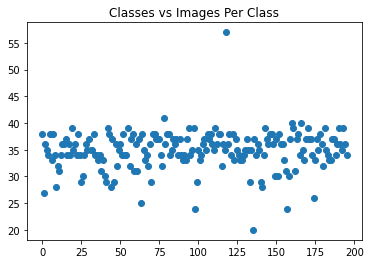

In [5]:
print('Training set size : {} , Validation set size: {}'.format(dataset_sizes[0], dataset_sizes[1]))
avg_image_num = mean(e[1] for e in dataset_classes_size[0])
print('The average images/class in the training set: ' +  str(int(avg_image_num)))
print()

# Plotting the distribution of the images / classes
plt.scatter(x, [e[1] for e in dataset_classes_size[0]])
plt.title('Classes vs Images Per Class')
plt.show() 

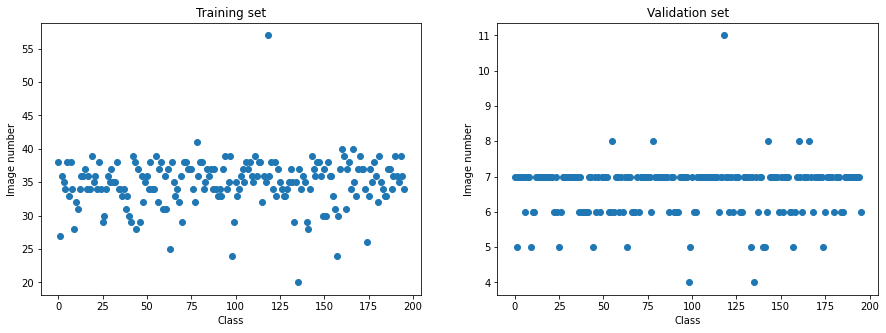

In [6]:
fig, axis = plt.subplots(nrows = 1, ncols = 2)
fig.set_size_inches(15,5)

dirs = ['Training set', 'Validation set']

for i in range(len(dataset_classes_size)):
    
    axis[i].scatter(x, [e[1] for e in dataset_classes_size[i]])
    axis[i].set_title(dirs[i])
    axis[i].set_xlabel('Class')
    axis[i].set_ylabel('Image number')


#### Preprocessing and splitting the dataset

In [7]:
# Function for preprocessing
def preprocess_data(img_size):

    # Transform data to tensor and normalize with mean=0.5 and standard deviation=0.5 for each channel
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            #transforms.RandomResizedCrop(img_size),
            transforms.RandomHorizontalFlip(),
            #transforms.RandomVerticalFlip(),
            #transforms.RandomAffine(degrees=40, scale=(.9, 1.1), shear=0),
            #transforms.RandomPerspective(distortion_scale=0.2),
            #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            #transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        
        'test': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            #transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    
    return data_transforms

# Function for loading the data
def load_data(root_folder, transformers, batch_size):

    # Load training set and apply transformations
    image_datasets            = {x: torchvision.datasets.ImageFolder(os.path.join(root_folder, x), transformers[x]) for x in ['train', 'val']}
    val_dataset, test_dataset = torch.utils.data.random_split(image_datasets['val'], [653, 652])
    image_datasets['val']     = val_dataset
    image_datasets['test']    = test_dataset
    
    dataloaders    = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size, shuffle = True, num_workers = 1) for x in ['train', 'val', 'test']}
    
    dataset_sizes  = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
    class_names    = image_datasets['train'].classes
    
    return image_datasets, dataloaders, dataset_sizes, class_names

# Function for convert an image to tensor
def img_to_tensor(img):
    
    img  = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img  = std * img + mean
    img  = np.clip(img, 0, 1)
    
    return img

# Displaying image
def imshow(img, figsize, title, fontsize):
    plt.figure(figsize = figsize)
    plt.title(title, fontsize = fontsize)
    plt.imshow(img)

In [8]:
# Preprocessing, loading and displaying the data
transformers                                              = preprocess_data(224)
image_datasets, dataloaders,  dataset_sizes, class_names  = load_data('dataset/', transformers, 32)

In [9]:
print(dataset_sizes)
print(len(class_names))

{'train': 6839, 'val': 653, 'test': 652}
196


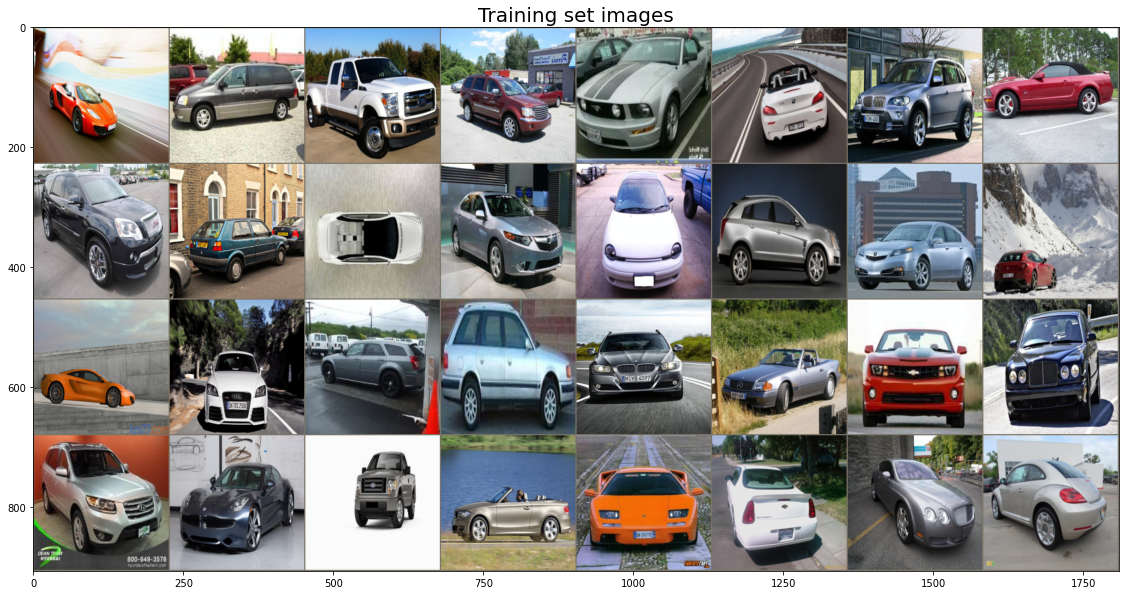

In [10]:
# Get some random training images
dataiter       = iter(dataloaders['train'])
images, labels = dataiter.next()

# Show images
img = img_to_tensor(torchvision.utils.make_grid(images))
imshow(img, (20, 10), 'Training set images', 20)


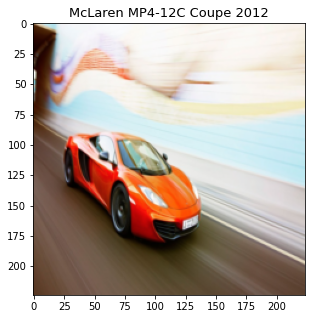

In [11]:
img0 = img_to_tensor(images[0])
imshow(img0, (10,5), class_names[labels[0]], 13)

## 2. Convolutional Neural Network Architecture
Load the CNN architecture you were given using pretrained weights. Define the optimizer and loss function. Train your network and save it. Remember to use Early stopping and show results.

#### Class for early stopping

In [12]:
class EarlyStopping():
    
    def __init__(self, model, model_name, patience = 3, min_delta = 0):
        
        self.model      = model
        self.best_model = model_name
        self.patience   = patience
        self.min_delta  = min_delta
        self.counter    = 0
        self.best_loss  = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.best_loss = val_loss
            self.counter   = 0
            torch.save(self.model.state_dict(),self.best_model)
        elif self.best_loss - val_loss > self.min_delta:
            self.counter += 1
            print(f'INFO: Early stopping counter {self.counter} of {self.patience}')
            
            if self.counter >= self.patience:
                print('INFO: Early stopping!') 
                self.early_stop = True

#### Functions for training process
 - train_model: Training the given model with the given parameters
 - evaluate_model: Evaluate the given model on the test set

In [13]:
def train_model(model, criterion, optimizer, scheduler, early_stopping,  num_epochs = 10):
    
    since = time.time()

    losses     = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc       = 0.0

    for epoch in range(num_epochs):
            
        print('Epoch {}/{} LR {:.6f}'.format(epoch + 1, num_epochs, scheduler.get_last_lr()[0]))
        print('-' * 10)

        epoch_start = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss     = 0.0
            running_corrects = 0

            # Iterate over data (mini-batches).
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs  = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss     = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss     += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc  = running_corrects.double() / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
       
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
            if phase == 'val':
                early_stopping(epoch_acc)

            
            if early_stopping.early_stop:
                return model, losses, accuracies

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            epoch_end = time.time()    

        print()
        print(str(epoch + 1) +  '. epoch complete in {:.0f}m {:.0f}s'.format( (epoch_end - epoch_start) // 60, (epoch_end - epoch_start) % 60))

    time_elapsed = time.time() - since

    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, losses, accuracies


def evaluate_model(model):

    correct_pred   = {classname: 0 for classname in class_names}
    total_pred     = {classname: 0 for classname in class_names}
    class_acc      = []
    correct_labels = []
    acc_per_class  = []
    y_true         = []
    y_pred         = []
    total          = 0
    correct        = 0


    was_training = model.training
    model.eval()

    with torch.no_grad():

        for i, (inputs, labels) in enumerate(dataloaders['test']):

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_pred.extend(preds.data.cpu().numpy())
            y_true.extend(labels.data.cpu().numpy())

            for label, prediction in zip(labels, preds):
                if label == prediction:
                    correct_pred[class_names [label] ] += 1
                    correct_labels.append(label)
                total_pred[class_names [label] ] += 1

            total += labels.size(0)
            correct += (preds == labels).sum().item()  
            
        model.train(mode=was_training)
            
    # Calculate the accuracy for each class
    for classname, correct_count in correct_pred.items():
        
        if total_pred[classname] != 0:
            accuracy = int(100 * float(correct_count) / total_pred[classname])
        else:
            accuracy = 0
        acc_per_class.append(accuracy)
        class_acc.append((classname, accuracy))

    return y_true, y_pred, correct_labels, acc_per_class, class_acc, total, correct
  

#### Functions for training, prediction and statistics visualization
 - visualize_model: Display the given number of images with the correct and predicted label
 - visualize_training: Display the training and validation accuracies and losses
 - visualize_statistics: Display metrics from training and validation (accuracy, recall, precision, balanced accuracy)
 - visualize_classes: Display each class with the corresponding accuracy in table format

In [14]:
def visualize_model(model, fig_size, num_images = 4):
    
    was_training = model.training
    model.eval()
    
    images_so_far = 0

    with torch.no_grad():

        for i, (inputs, labels) in enumerate(dataloaders['test']):

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            tot = num_images
            cols = 5

            # Compute Rows required
            rows = tot // cols 
            rows += tot % cols

            # Create a Position index and a figure
            position = range(1,tot + 1)
            fig = plt.figure(1, figsize = (20, 20))

            for j, (label, prediction) in enumerate(zip(labels, preds)):
                
                # add every single subplot to the figure with a for loop
                img = img_to_tensor(inputs.cpu().data[j])

                ax = fig.add_subplot(rows, cols, position[j])
                ax.set_title('predicted: {} actual: {}'.format(prediction, label))
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.imshow(img) 
                
                images_so_far += 1

                if images_so_far == num_images:

                    model.train(mode=was_training)
                    return

        model.train(mode=was_training) 
        
def visualize_training(accuracies, losses, fname_1, fname_2):
    
    plt.figure(figsize=(10, 7))

    plt.plot([x.item() for x in accuracies['train']], color = 'green', label = 'train accuracy')
    plt.plot([x.item() for x in accuracies['val']],   color = 'blue',  label = 'validation accuracy')
    plt.legend()
    plt.savefig(fname_1)
    plt.show()

    plt.figure(figsize=(10, 7))

    plt.plot(losses['train'], color = 'orange', label = 'train loss')
    plt.plot(losses['val'],   color = 'red',    label = 'validation loss')
    plt.legend()
    plt.savefig(fname_2)
    plt.show()
    
def visualize_statistics(y_true, y_pred):
    
    # Statistics and metrics

    accuracy          = accuracy_score(y_true, y_pred)
    recall            = recall_score(y_true, y_pred, average = 'macro')
    precision         = precision_score(y_true, y_pred, average = 'macro')
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)


    print(classification_report(y_true, y_pred))
    print()
    print("Accuracy of the total model is {:.2f}".format(accuracy * 100) + '%')
    print("Recall of the total model is {:.2f}".format(recall * 100) + '%')
    print("Precision of the total model is {:.2f}".format(precision * 100) + '%')
    print("Balanced accuracy of the total model is {:.2f}".format(balanced_accuracy * 100) + '%')
    
def visualize_classes(total, correct, class_acc):
    
    col_names = ['Class', 'Accuracy']

    print('Accuracy of the network on ' + str(total) + ' test images: %d %%' % (100 * correct / total))
    print()
    print()

    class_acc.sort(key = lambda x:x[1], reverse = True)
    c = dict(Counter([x[1] for x in class_acc]))

    print(tabulate(class_acc, headers = col_names, tablefmt = "fancy_grid"))
    print()
    print(c)
    
    class_sum = 0
    
    for (key, value) in c.items():
        
        if key >= 50:
            class_sum += value
    print()
    print('There were 196/' + str(class_sum) + ' classes whose accuracies were better than 50%.')
    
    

#### Load the architecture

## 2.1 Pretrained, frozen model
With this approach, we got poor accuracy and flat training curve because in this case, the model is underfitting. One of the problems could be that is VGG16 was trained on the ImageNet database, and our Stanford Cars database differs from that. In this case, we changed the last Dense layer output only. In this case we got:
 - Accuracy of the total model is 23.93%
 - Recall of the total model is 22.97%
 - Precision of the total model is 23.99%
 - Balanced accuracy of the total model is 23.09%
 
There were 196/40 classes whose accuracies were better than 50%.

In [15]:
model_frozen = models.vgg16(pretrained=True)

for param in model_frozen.parameters():
    param.requires_grad = False

num_ftrs = model_frozen.classifier[6].in_features

model_frozen.classifier[6] = nn.Linear(num_ftrs, 196)
model_frozen = model_frozen.to(device)

pytorch_total_params = sum(p.numel() for p in model_frozen.parameters() if p.requires_grad)
print(model_frozen)
print(pytorch_total_params)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### Define your optimizer and loss function

In [16]:
criterion_frozen        = nn.CrossEntropyLoss()
optimizer_frozen        = optim.SGD(model_frozen.classifier.parameters(), lr = 0.001, momentum = 0.9)
exp_lr_scheduler_frozen = lr_scheduler.StepLR(optimizer_frozen, step_size = 4, gamma = 0.1)

# Early stopping
early_stopping = EarlyStopping(model_frozen, 'model_frozen.pth', 2)

#### Train your network

In [17]:
model_frozen, losses_frozen, accuracies_frozen = train_model(model_frozen,
                                                                criterion_frozen,
                                                                optimizer_frozen,
                                                                exp_lr_scheduler_frozen,
                                                                early_stopping,
                                                                num_epochs = 20)

Epoch 1/20 LR 0.001000
----------
train Loss: 4.9442 Acc: 0.0390
val Loss: 4.4213 Acc: 0.0904

1. epoch complete in 0m 52s
Epoch 2/20 LR 0.001000
----------
train Loss: 4.2222 Acc: 0.1123
val Loss: 4.0004 Acc: 0.1792

2. epoch complete in 0m 54s
Epoch 3/20 LR 0.001000
----------
train Loss: 3.8278 Acc: 0.1654
val Loss: 3.7471 Acc: 0.2037

3. epoch complete in 0m 54s
Epoch 4/20 LR 0.001000
----------
train Loss: 3.5575 Acc: 0.2111
val Loss: 3.5927 Acc: 0.2205

4. epoch complete in 0m 52s
Epoch 5/20 LR 0.000100
----------
train Loss: 3.3557 Acc: 0.2617
val Loss: 3.5499 Acc: 0.2343

5. epoch complete in 0m 53s
Epoch 6/20 LR 0.000100
----------
train Loss: 3.3276 Acc: 0.2688
val Loss: 3.5293 Acc: 0.2404

6. epoch complete in 0m 54s
Epoch 7/20 LR 0.000100
----------
train Loss: 3.3034 Acc: 0.2803
val Loss: 3.5143 Acc: 0.2511

7. epoch complete in 0m 53s
Epoch 8/20 LR 0.000100
----------
train Loss: 3.2960 Acc: 0.2784
val Loss: 3.4998 Acc: 0.2527

8. epoch complete in 0m 53s
Epoch 9/20 LR 0.

#### Show results (accuracy and loss) on training and validation sets

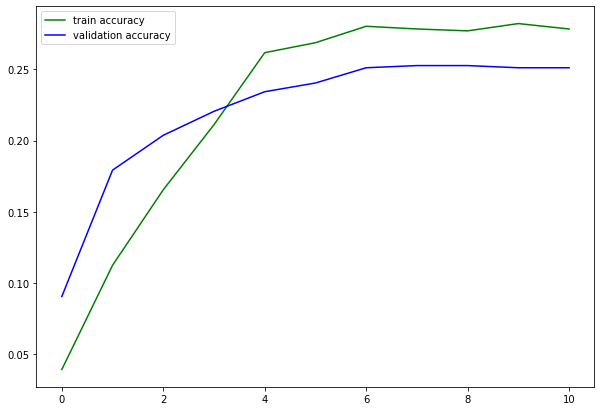

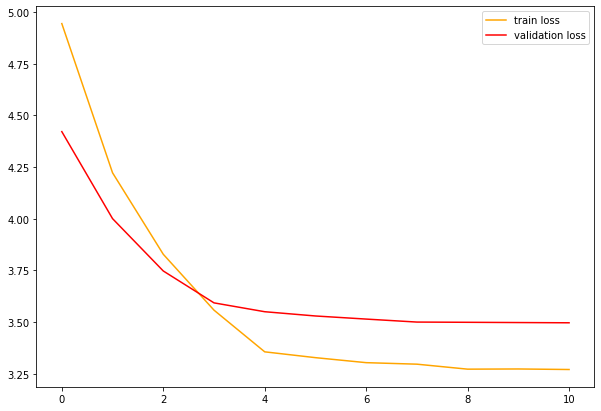

In [18]:
visualize_training(accuracies_frozen, losses_frozen, 'accuracies_frozen.png', 'losses_frozen.png')

#### Save the model

In [19]:
torch.save(model_frozen.state_dict(), 'model_frozen_new.pth')

#### Evaluate your model

In [20]:
y_true_frozen, y_pred_frozen, correct_labels_frozen, acc_per_class_frozen, class_acc_frozen, total_frozen, correct_frozen = evaluate_model(model_frozen)

In [21]:
visualize_statistics(y_true_frozen, y_pred_frozen)

              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         0
           3       1.00      0.25      0.40         4
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         3
           8       0.50      0.33      0.40         3
           9       0.00      0.00      0.00         4
          10       0.25      0.50      0.33         2
          11       0.33      0.33      0.33         3
          12       0.50      0.25      0.33         4
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         3
          15       0.40      0.50      0.44         4
          16       0.00      0.00      0.00         3
          17       0.00    

c:\users\habon\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\habon\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\habon\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\users\habon\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMet

In [22]:
visualize_classes(total_frozen, correct_frozen, class_acc_frozen)

Accuracy of the network on 652 test images: 23 %


╒════════════════════════════════════════════════════════╤════════════╕
│ Class                                                  │   Accuracy │
╞════════════════════════════════════════════════════════╪════════════╡
│ Chevrolet HHR SS 2010                                  │        100 │
├────────────────────────────────────────────────────────┼────────────┤
│ Dodge Caravan Minivan 1997                             │        100 │
├────────────────────────────────────────────────────────┼────────────┤
│ Eagle Talon Hatchback 1998                             │        100 │
├────────────────────────────────────────────────────────┼────────────┤
│ HUMMER H2 SUT Crew Cab 2009                            │        100 │
├────────────────────────────────────────────────────────┼────────────┤
│ Jeep Grand Cherokee SUV 2012                           │        100 │
├────────────────────────────────────────────────────────┼────────────┤
│ Volvo 240 S

## 2.2 Pretrained model with frozen CNN layers
With this approach, we got high training and validation accuracy and small training and validation losses. This is a necessary step because without that the model would not able to generalize well. The approach is the following:
 - Freeze the first 19 layers
 - Retrain the remaining layers 
 - Change the last classifier (Dense) layer 
 
We used SGD optimizer with a relatively large learning rate for fast training purposes and dynamically reduced the learning rate (every fourth epoch). We used the early stopping technique in order to avoid overfitting. In this case we got:

 - Accuracy of the total model is 71.63%
 - Recall of the total model is 71.88%
 - Precision of the total model is 70.76%
 - Balanced accuracy of the total model is 72.25%
 
There were 196/160 classes whose accuracies were better than 50%.


In [23]:
# ADD YOUR CODE HERE

vgg16 = models.vgg16(pretrained=True)

for param in vgg16.parameters():
    param.requires_grad = False

for param in vgg16.features[19:].parameters():
    param.requires_grad = True

num_ftrs            = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, 196)
vgg16               = vgg16.to(device)

#### Define your optimizer and loss function

In [24]:
# ADD YOUR CODE HERE

criterion_vgg16        = nn.CrossEntropyLoss()
optimizer_vgg16        = optim.SGD(vgg16.parameters(), lr = 0.01, momentum = 0.9)
exp_lr_scheduler_vgg16 = lr_scheduler.StepLR(optimizer_vgg16, step_size = 4, gamma = 0.1)

# Early stopping

early_stopping_vgg16 = EarlyStopping(vgg16, 'model_vgg16.pth', 3)

In [25]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)
torch.cuda.memory_stats(device=None)

OrderedDict([('active.all.allocated', 152819),
             ('active.all.current', 111),
             ('active.all.freed', 152708),
             ('active.all.peak', 124),
             ('active.large_pool.allocated', 98909),
             ('active.large_pool.current', 26),
             ('active.large_pool.freed', 98883),
             ('active.large_pool.peak', 39),
             ('active.small_pool.allocated', 53910),
             ('active.small_pool.current', 85),
             ('active.small_pool.freed', 53825),
             ('active.small_pool.peak', 85),
             ('active_bytes.all.allocated', 10301932138496),
             ('active_bytes.all.current', 1088595456),
             ('active_bytes.all.freed', 10300843543040),
             ('active_bytes.all.peak', 2341350400),
             ('active_bytes.large_pool.allocated', 10295048506880),
             ('active_bytes.large_pool.current', 1086390272),
             ('active_bytes.large_pool.freed', 10293962116608),
             ('activ

#### Train your network

In [26]:
vgg16, losses, accuracies = train_model(vgg16,
                                        criterion_vgg16,
                                        optimizer_vgg16,
                                        exp_lr_scheduler_vgg16,
                                        early_stopping_vgg16,
                                        num_epochs = 20)

Epoch 1/20 LR 0.010000
----------
train Loss: 4.7884 Acc: 0.0423
val Loss: 3.9634 Acc: 0.1271

1. epoch complete in 0m 47s
Epoch 2/20 LR 0.010000
----------
train Loss: 3.4357 Acc: 0.1896
val Loss: 2.9916 Acc: 0.2466

2. epoch complete in 0m 50s
Epoch 3/20 LR 0.010000
----------
train Loss: 2.5337 Acc: 0.3451
val Loss: 2.4893 Acc: 0.3629

3. epoch complete in 0m 50s
Epoch 4/20 LR 0.010000
----------
train Loss: 1.9130 Acc: 0.4838
val Loss: 2.0382 Acc: 0.4671

4. epoch complete in 0m 50s
Epoch 5/20 LR 0.001000
----------
train Loss: 0.9114 Acc: 0.7217
val Loss: 1.1678 Acc: 0.6815

5. epoch complete in 0m 50s
Epoch 6/20 LR 0.001000
----------
train Loss: 0.6210 Acc: 0.8092
val Loss: 1.1196 Acc: 0.7029

6. epoch complete in 0m 50s
Epoch 7/20 LR 0.001000
----------
train Loss: 0.5037 Acc: 0.8437
val Loss: 1.0917 Acc: 0.7152

7. epoch complete in 0m 50s
Epoch 8/20 LR 0.001000
----------
train Loss: 0.4466 Acc: 0.8580
val Loss: 1.0654 Acc: 0.7198

8. epoch complete in 0m 50s
Epoch 9/20 LR 0.

#### Show results (accuracy and loss) on training and validation sets

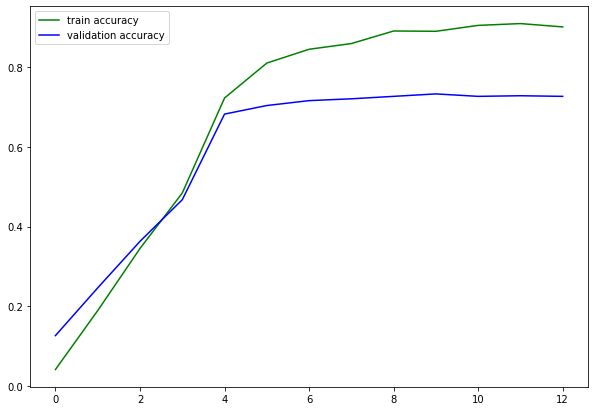

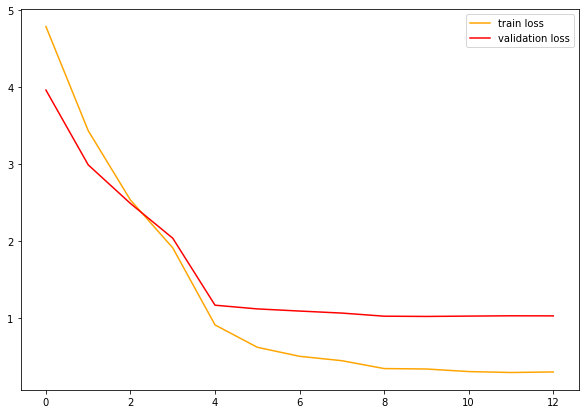

In [27]:
# ADD YOUR CODE HERE

visualize_training(accuracies, losses, 'accuracies.png', 'losses.png')

#### Save the model

In [28]:
torch.save(vgg16.state_dict(), 'vgg16_model_new.pth')

## 3. Conclusion (Evaluation)
Load your trained CNN and evaluate it on the test set. Show some predictions on the test set (3 is enough) by ploting the image and printing the prediction and ground truth.

How good are your results? Do you think the network is overfitted or underfitted? If yes, what do you think lead to that? If not, justify.

#### Evaluate your model

In [29]:
# ADD YOUR CODE HERE

y_true, y_pred, correct_labels, acc_per_class, class_acc, total, correct = evaluate_model(vgg16)

In [30]:
# Statistics and metrics

visualize_statistics(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       1.00      0.67      0.80         3
           2       0.00      0.00      0.00         0
           3       0.57      1.00      0.73         4
           4       0.80      1.00      0.89         4
           5       1.00      0.50      0.67         4
           6       0.67      1.00      0.80         2
           7       0.50      0.67      0.57         3
           8       1.00      0.67      0.80         3
           9       0.50      0.50      0.50         4
          10       0.33      0.50      0.40         2
          11       1.00      0.67      0.80         3
          12       0.50      0.50      0.50         4
          13       0.67      1.00      0.80         4
          14       0.75      1.00      0.86         3
          15       0.75      0.75      0.75         4
          16       0.50      0.67      0.57         3
          17       1.00    

c:\users\habon\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\habon\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\habon\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\users\habon\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMet

In [31]:
# Visualize classes and accuracies

visualize_classes(total, correct, class_acc)

Accuracy of the network on 652 test images: 70 %


╒════════════════════════════════════════════════════════╤════════════╕
│ Class                                                  │   Accuracy │
╞════════════════════════════════════════════════════════╪════════════╡
│ Acura TL Sedan 2012                                    │        100 │
├────────────────────────────────────────────────────────┼────────────┤
│ Acura TL Type-S 2008                                   │        100 │
├────────────────────────────────────────────────────────┼────────────┤
│ Acura ZDX Hatchback 2012                               │        100 │
├────────────────────────────────────────────────────────┼────────────┤
│ Audi A5 Coupe 2012                                     │        100 │
├────────────────────────────────────────────────────────┼────────────┤
│ Audi R8 Coupe 2012                                     │        100 │
├────────────────────────────────────────────────────────┼────────────┤
│ Audi S6 Sed

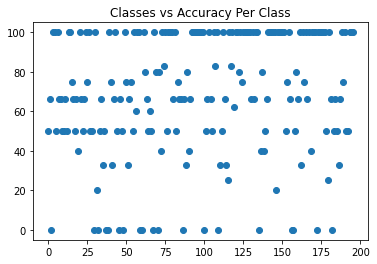

In [32]:
# Plotting the accuracy of the classes
plt.scatter([x for x in range(196)], acc_per_class)
plt.title('Classes vs Accuracy Per Class')
plt.show() 

#### Show some predictions

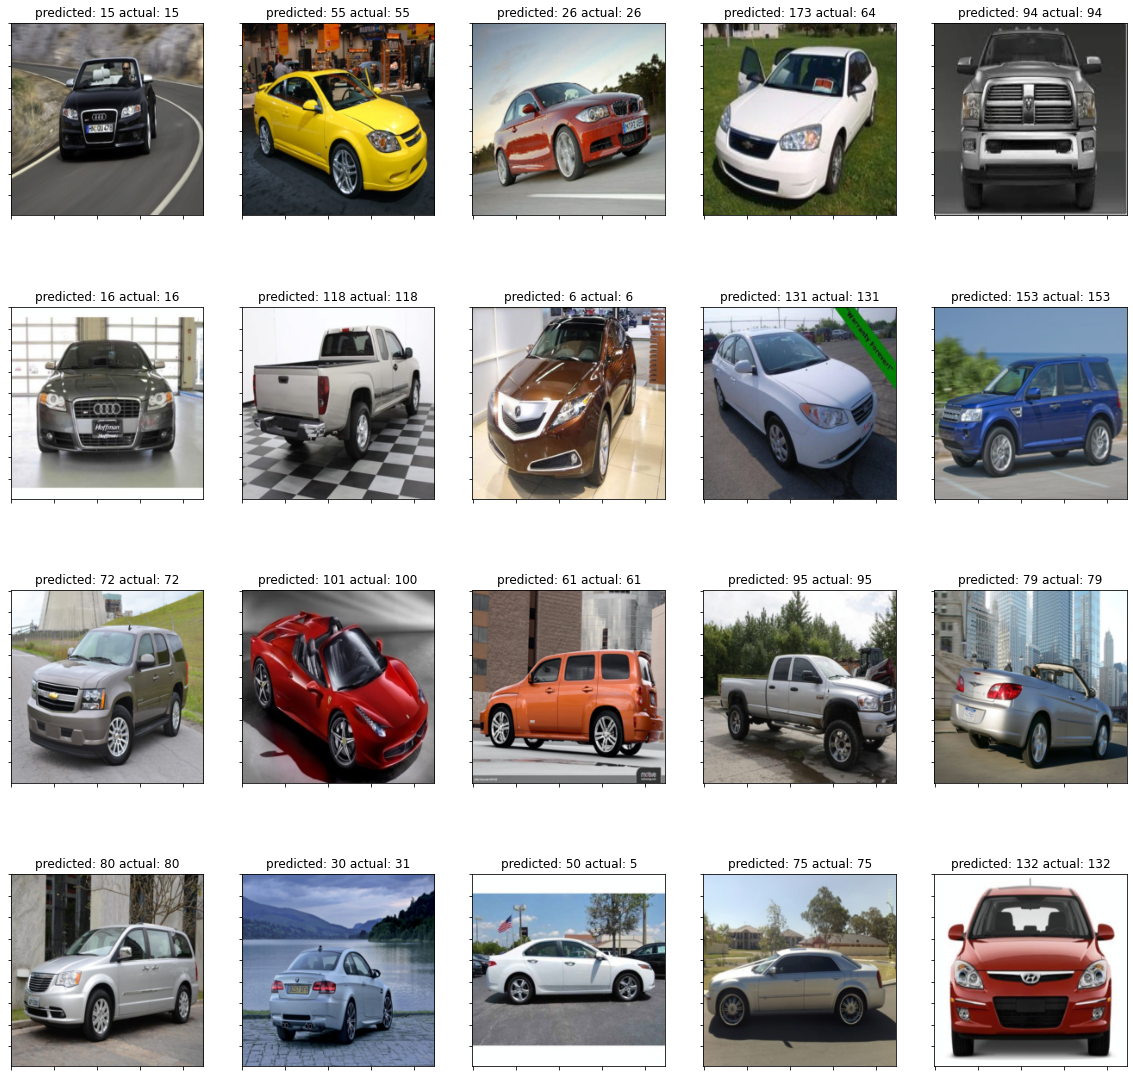

In [33]:
# ADD YOUR CODE HERE

visualize_model(vgg16, (10, 5), 20)

#### Convert to HTML format

In [ ]:
os.system('jupyter nbconvert --to html Cars_classification_VGG16.ipynb')

#### Answer the questions

How good are your results? 

We have approximately 26% accuracy with the frozen model and 73% accuracy with the Fine-tuned unfrozen model.

Do you think the network is overfitted or underfitted? 

With the frozen model it's clearly underfitted because VGG16 was trained on the ImageNet database, and our Stanford Cars database differs from that. The unfrozen model is little bit overfitted.